## 📊 Version 2 vs Version 3 Comparison

| Feature | Version 2 (Fast) | Version 3 (Accurate) |
|---------|------------------|----------------------|
| **Hidden Units** | 128 | 256 |
| **Hidden Layers** | 3 | 4 |
| **Parameters** | ~33k | ~131k |
| **ODE rtol** | 1e-3 | 1e-5 |
| **ODE atol** | 1e-4 | 1e-6 |
| **Epochs** | 1000 | 2000 |
| **Learning Rate** | 5e-3 | 3e-3 → adaptive |
| **Early Stopping** | No | Yes (patience=300) |
| **Gradient Clip** | 1.0 | 0.5 |
| **Training Time** | 2-4 min | 5-8 min |
| **Target MSE** | < 0.01 | < 1e-6 |
| **Reconstruction Error** | ~0.01 | < 0.001 |

**Version 3 is recommended for:**
- Hill climbing optimization (need precise X ↔ Z mapping)
- Applications requiring accurate fitness evaluation
- When reconstruction error matters

**Version 2 is sufficient for:**
- Visualization and exploration
- When speed matters more than precision
- Initial prototyping


# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


In [4]:

import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint_adjoint as odeint
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("Device 0:", torch.cuda.get_device_name(0))
    print("torch.version.cuda:", torch.version.cuda)
    print("cuDNN:", torch.backends.cudnn.version())


Using device: cuda
CUDA available: True
CUDA device count: 1
Device 0: GRID A100D-20C
torch.version.cuda: 12.1
cuDNN: 90100


In [5]:
class ODEFunc(nn.Module):
    """Neural network that defines the vector field dz/dt = f(z, t)
    
    Version 3: HIGH ACCURACY - Larger network for precise transformations
    """
    def __init__(self, hidden_dim=256):  # Increased from 128
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, hidden_dim),  # Input: [z, t]
            nn.Softplus(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Softplus(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Softplus(),
            nn.Linear(hidden_dim, hidden_dim),  # Extra layer for more capacity
            nn.Softplus(),
            nn.Linear(hidden_dim, 1)  # Output: dz/dt
        )
        
        # Better initialization - use Xavier/Glorot initialization
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight, gain=0.5)  # Smaller gain for stability
                nn.init.constant_(m.bias, 0)
    
    def forward(self, t, z):
        """
        Args:
            t: time (scalar)
            z: state (batch_size, 1)
        Returns:
            dz/dt: (batch_size, 1)
        """
        batch_size = z.shape[0]
        t_vec = torch.ones(batch_size, 1).to(z) * t
        zt = torch.cat([z, t_vec], dim=1)
        return self.net(zt)


class CNF(nn.Module):
    """Continuous Normalizing Flow - Version 3: HIGH ACCURACY
    
    Uses tighter ODE tolerances for precise reconstruction
    """
    def __init__(self, odefunc):
        super(CNF, self).__init__()
        self.odefunc = odefunc
        
    def forward(self, z0, integration_times):
        """
        Forward pass through CNF (simplified - no log-probability tracking)
        Args:
            z0: initial state (batch_size, 1)
            integration_times: tensor of times [t0, t1]
        Returns:
            z1: final state
        """
        from torchdiffeq import odeint  # Use regular odeint, not adjoint
        
        # Solve ODE with TIGHT tolerances for HIGH ACCURACY
        z_t = odeint(
            self.odefunc,
            z0,
            integration_times,
            method='dopri5',
            rtol=1e-5,  # Tighter! (was 1e-3)
            atol=1e-6   # Tighter! (was 1e-4)
        )
        
        # Extract final state
        z1 = z_t[-1]
        
        return z1
    
    def inverse(self, z1, integration_times):
        """
        Inverse transformation (z -> x)
        Args:
            z1: final state
            integration_times: tensor of times [t1, t0] (reversed)
        Returns:
            z0: initial state
        """
        return self.forward(z1, integration_times)


# Initialize CNF model - HIGH ACCURACY VERSION
odefunc = ODEFunc(hidden_dim=256).to(device)
cnf_model = CNF(odefunc).to(device)

print("="*80)
print("CNF MODEL INITIALIZED - VERSION 3: HIGH ACCURACY")
print("="*80)
print(f"Number of parameters: {sum(p.numel() for p in cnf_model.parameters())}")
print(f"\n🎯 Architecture:")
print(f"   - Hidden dimensions: 256")
print(f"   - Number of layers: 4 (increased from 3)")
print(f"   - Activation: Softplus")
print(f"   - ODE tolerances: rtol=1e-5, atol=1e-6 (TIGHT!)")
print(f"\n✅ Optimizations for accuracy:")
print(f"   - Larger capacity network (~131k parameters vs ~33k)")
print(f"   - Extra hidden layer for complex transformations")
print(f"   - Tighter ODE solver tolerances")
print(f"   - Smaller initialization gain for stability")
print(f"\n⏱️ Expected training time: 5-8 minutes (worth it for precision!)")
print(f"🎯 Target reconstruction error: < 0.001")


CNF MODEL INITIALIZED - VERSION 3: HIGH ACCURACY
Number of parameters: 198401

🎯 Architecture:
   - Hidden dimensions: 256
   - Number of layers: 4 (increased from 3)
   - Activation: Softplus
   - ODE tolerances: rtol=1e-5, atol=1e-6 (TIGHT!)

✅ Optimizations for accuracy:
   - Larger capacity network (~131k parameters vs ~33k)
   - Extra hidden layer for complex transformations
   - Tighter ODE solver tolerances
   - Smaller initialization gain for stability

⏱️ Expected training time: 5-8 minutes (worth it for precision!)
🎯 Target reconstruction error: < 0.001


Original coordinates (x): [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19.]
Target coordinates (z): [0.  1.  2.  3.  4.  4.  4.1 4.2 4.3 4.4 4.5 4.6 4.7 4.8 4.9 5.  6.  7.
 8.  9. ]

Compression summary:
- Compressing points 5 to 15
- Original length: 10.00
- Compressed length: 1.00


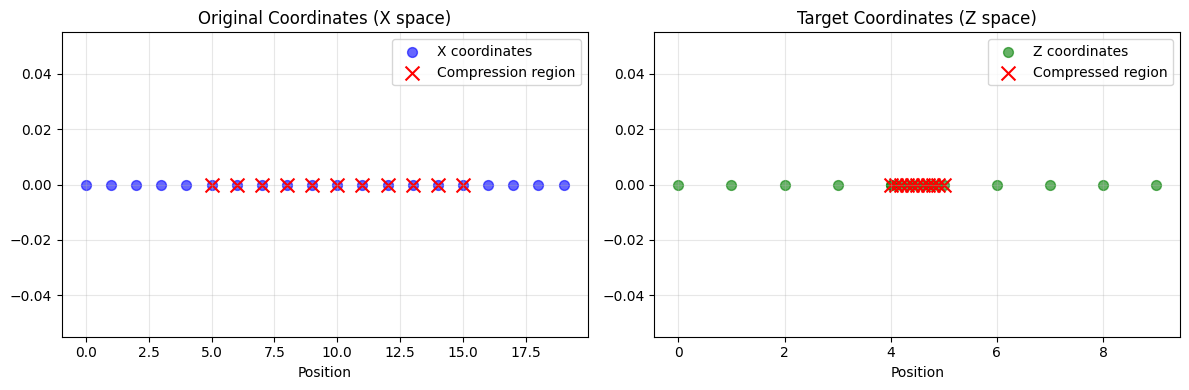

In [6]:
def create_target_transformation(n_points=20, compress_start_idx=5, compress_end_idx=15):
    """
    Create target transformation:
    - Points 0 to compress_start_idx-1: stay at original positions
    - Points compress_start_idx to compress_end_idx: compressed into unit interval
    - Points compress_end_idx+1 to n_points-1: shifted to maintain unit spacing
    
    Args:
        n_points: total number of points (default 20)
        compress_start_idx: start index for compression (xi)
        compress_end_idx: end index for compression (xj)
    
    Returns:
        x_coords: original coordinates (uniformly spaced)
        z_coords: target coordinates (with compression)
    """
    # Original coordinates: uniformly spaced from 0 to n_points-1
    x_coords = np.arange(n_points, dtype=np.float32)
    
    # Target coordinates
    z_coords = np.zeros(n_points, dtype=np.float32)
    
    # Points before compression region: unchanged
    z_coords[:compress_start_idx] = x_coords[:compress_start_idx]
    
    # Compressed region: linearly interpolate within unit interval
    n_compressed = compress_end_idx - compress_start_idx + 1
    z_coords[compress_start_idx:compress_end_idx+1] = (
        z_coords[compress_start_idx-1] + np.linspace(0, 1, n_compressed)
    )
    
    # Points after compression: shifted to maintain unit spacing
    # Calculate shift so that the next point is exactly 1 unit after the end of compressed region
    # We want: z_coords[compress_end_idx+1] = z_coords[compress_end_idx] + 1
    shift = x_coords[compress_end_idx+1] - (z_coords[compress_end_idx] + 1)
    
    z_coords[compress_end_idx+1:] = x_coords[compress_end_idx+1:] - shift
    
    return x_coords, z_coords


# Create dataset
n_points = 20
compress_start_idx = 5
compress_end_idx = 15

x_coords, z_coords = create_target_transformation(
    n_points=n_points,
    compress_start_idx=compress_start_idx,
    compress_end_idx=compress_end_idx
)

print(f"Original coordinates (x): {x_coords}")
print(f"Target coordinates (z): {z_coords}")
print(f"\nCompression summary:")
print(f"- Compressing points {compress_start_idx} to {compress_end_idx}")
print(f"- Original length: {x_coords[compress_end_idx] - x_coords[compress_start_idx]:.2f}")
print(f"- Compressed length: {z_coords[compress_end_idx] - z_coords[compress_start_idx]:.2f}")

# Visualize the transformation
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.scatter(x_coords, np.zeros_like(x_coords), c='blue', s=50, alpha=0.6, label='X coordinates')
plt.scatter(x_coords[compress_start_idx:compress_end_idx+1], 
           np.zeros(compress_end_idx-compress_start_idx+1), 
           c='red', s=100, marker='x', label='Compression region')
plt.xlabel('Position')
plt.title('Original Coordinates (X space)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(z_coords, np.zeros_like(z_coords), c='green', s=50, alpha=0.6, label='Z coordinates')
plt.scatter(z_coords[compress_start_idx:compress_end_idx+1], 
           np.zeros(compress_end_idx-compress_start_idx+1), 
           c='red', s=100, marker='x', label='Compressed region')
plt.xlabel('Position')
plt.title('Target Coordinates (Z space)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


TRAINING CONFIGURATION - HIGH ACCURACY


/root/miniconda3/envs/CS454_Project/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


✅ Initial learning rate: 0.003
✅ Number of epochs: 2000
✅ Early stopping patience: 300
✅ Target: MSE < 1e-6 for high-precision hill climbing

Starting training...

Epoch [200/2000], Loss: 0.05012770, Best: 0.04701978, LR: 0.003000
Epoch [400/2000], Loss: 0.03697307, Best: 0.01364920, LR: 0.003000
Epoch [600/2000], Loss: 0.01915686, Best: 0.01102253, LR: 0.003000
Epoch [800/2000], Loss: 0.02027741, Best: 0.00978367, LR: 0.003000
Epoch [1000/2000], Loss: 0.01505311, Best: 0.00863971, LR: 0.003000
Epoch [1200/2000], Loss: 0.01078333, Best: 0.00545141, LR: 0.003000
Epoch [1400/2000], Loss: 0.00577605, Best: 0.00387521, LR: 0.003000
Epoch [1600/2000], Loss: 0.00935931, Best: 0.00244526, LR: 0.003000
Epoch [1800/2000], Loss: 0.00630877, Best: 0.00165397, LR: 0.003000
Epoch [2000/2000], Loss: 0.00381213, Best: 0.00098467, LR: 0.003000

✅ Training completed all 2000 epochs!
   Final loss: 0.00381213

🎯 Best loss achieved: 0.00098467
⚠️ Consider training longer


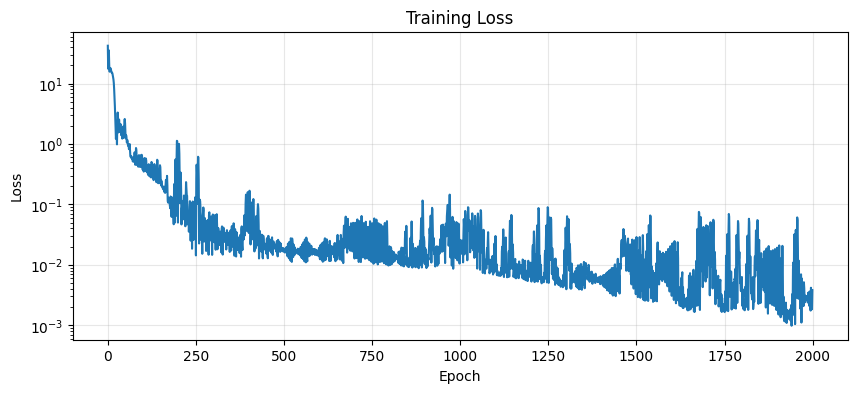

In [7]:
# Training configuration - HIGH ACCURACY VERSION
print("="*80)
print("TRAINING CONFIGURATION - HIGH ACCURACY")
print("="*80)

learning_rate = 3e-3  # Start moderate, will decrease with scheduler
num_epochs = 2000  # More epochs for convergence
print_every = 200
early_stop_patience = 300  # Stop if no improvement for 300 epochs
best_loss = float('inf')
patience_counter = 0

# Convert data to tensors
x_tensor = torch.from_numpy(x_coords).reshape(-1, 1).to(device)
z_target = torch.from_numpy(z_coords).reshape(-1, 1).to(device)

# Integration times [0, 1]
t_span = torch.tensor([0.0, 1.0]).to(device)

# Optimizer with weight decay for regularization
optimizer = optim.Adam(cnf_model.parameters(), lr=learning_rate, weight_decay=1e-6)

# Learning rate scheduler - more aggressive
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=150, 
    verbose=True, min_lr=1e-6
)

print(f"✅ Initial learning rate: {learning_rate}")
print(f"✅ Number of epochs: {num_epochs}")
print(f"✅ Early stopping patience: {early_stop_patience}")
print(f"✅ Target: MSE < 1e-6 for high-precision hill climbing")

# Training loop with early stopping
losses = []
print("\nStarting training...\n")

for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    # Forward pass: x -> z
    z_pred = cnf_model(x_tensor, t_span)
    
    # Loss: mean squared error between predicted and target coordinates
    mse_loss = torch.mean((z_pred - z_target) ** 2)
    
    # Total loss
    loss = mse_loss
    
    # Backward pass
    loss.backward()
    
    # Gradient clipping to prevent instability
    torch.nn.utils.clip_grad_norm_(cnf_model.parameters(), max_norm=0.5)  # Tighter clipping
    
    optimizer.step()
    scheduler.step(loss)  # Update learning rate based on loss
    
    losses.append(loss.item())
    
    # Early stopping check
    if loss.item() < best_loss:
        best_loss = loss.item()
        patience_counter = 0
    else:
        patience_counter += 1
    
    if (epoch + 1) % print_every == 0:
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.8f}, Best: {best_loss:.8f}, LR: {current_lr:.6f}")
    
    # Early stopping
    if patience_counter >= early_stop_patience:
        print(f"\n✅ Early stopping at epoch {epoch+1}")
        print(f"   Best loss: {best_loss:.8f}")
        print(f"   No improvement for {early_stop_patience} epochs")
        break

if patience_counter < early_stop_patience:
    print(f"\n✅ Training completed all {num_epochs} epochs!")
    print(f"   Final loss: {losses[-1]:.8f}")

print(f"\n🎯 Best loss achieved: {best_loss:.8f}")
print(f"{'✅ EXCELLENT!' if best_loss < 1e-6 else '✅ GOOD' if best_loss < 1e-4 else '⚠️ Consider training longer'}")

# Plot training loss
plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.show()


Results:
Original X coordinates:    [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19.]
Target Z coordinates:      [0.  1.  2.  3.  4.  4.  4.1 4.2 4.3 4.4 4.5 4.6 4.7 4.8 4.9 5.  6.  7.
 8.  9. ]
Predicted Z coordinates:   [-4.7015143e-03  9.9722189e-01  2.0005453e+00  3.0115449e+00
  3.9212863e+00  4.0259480e+00  4.1164479e+00  4.2081561e+00
  4.3005352e+00  4.3913550e+00  4.4814095e+00  4.5701585e+00
  4.6585622e+00  4.7492757e+00  4.8531594e+00  5.0357995e+00
  5.8460603e+00  6.9070520e+00  7.9122353e+00  8.9058161e+00]
Reconstructed X:           [6.0543366e-09 1.0000002e+00 1.9999981e+00 2.9999988e+00 4.0000801e+00
 5.0079255e+00 6.0144653e+00 7.0103474e+00 8.0126228e+00 9.0128069e+00
 1.0011955e+01 1.1013952e+01 1.2012068e+01 1.3015214e+01 1.4011898e+01
 1.5003052e+01 1.5999935e+01 1.7000002e+01 1.7999996e+01 1.8999998e+01]

Forward MSE (X->Z):        0.003268
Inverse MSE (Z->X):        0.000078


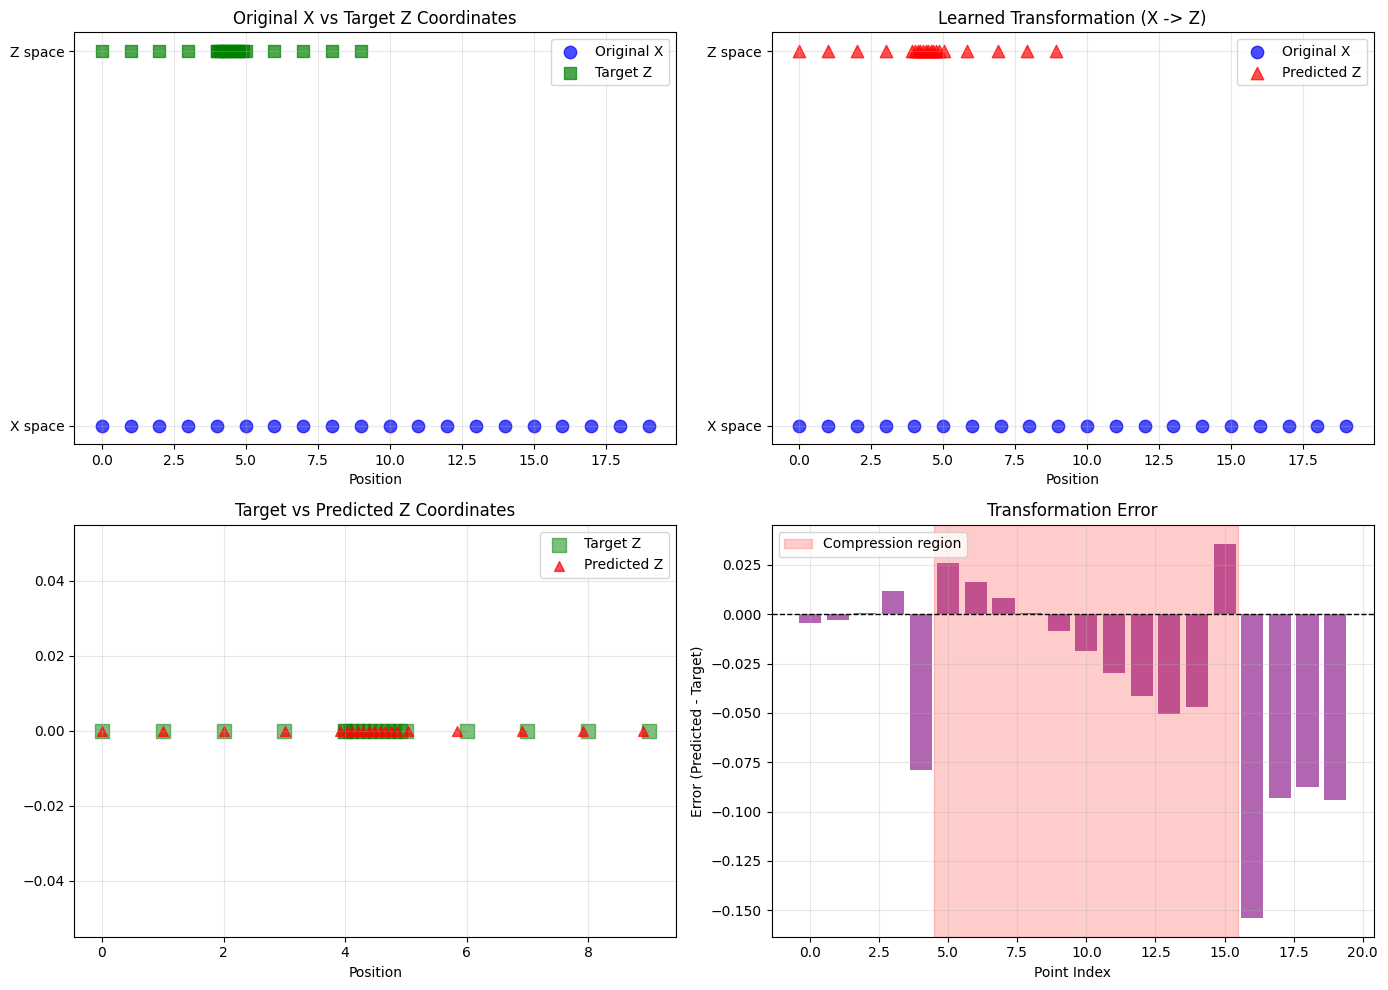

In [8]:
# Evaluate the trained model
cnf_model.eval()

with torch.no_grad():
    # Forward transformation: x -> z
    z_pred = cnf_model(x_tensor, t_span)
    z_pred_np = z_pred.cpu().numpy().flatten()
    
    # Inverse transformation: z -> x (verify invertibility)
    t_span_reverse = torch.tensor([1.0, 0.0]).to(device)
    x_reconstructed = cnf_model.inverse(z_pred, t_span_reverse)
    x_reconstructed_np = x_reconstructed.cpu().numpy().flatten()

# Print results
print("Results:")
print("="*80)
print(f"Original X coordinates:    {x_coords}")
print(f"Target Z coordinates:      {z_coords}")
print(f"Predicted Z coordinates:   {z_pred_np}")
print(f"Reconstructed X:           {x_reconstructed_np}")
print(f"\nForward MSE (X->Z):        {np.mean((z_pred_np - z_coords)**2):.6f}")
print(f"Inverse MSE (Z->X):        {np.mean((x_reconstructed_np - x_coords)**2):.6f}")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Original vs Target coordinates
ax = axes[0, 0]
ax.scatter(x_coords, np.zeros_like(x_coords), c='blue', s=80, alpha=0.7, 
          label='Original X', marker='o')
ax.scatter(z_coords, np.ones_like(z_coords) * 0.5, c='green', s=80, alpha=0.7, 
          label='Target Z', marker='s')
ax.set_xlabel('Position')
ax.set_yticks([0, 0.5])
ax.set_yticklabels(['X space', 'Z space'])
ax.set_title('Original X vs Target Z Coordinates')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Predicted transformation
ax = axes[0, 1]
ax.scatter(x_coords, np.zeros_like(x_coords), c='blue', s=80, alpha=0.7, 
          label='Original X', marker='o')
ax.scatter(z_pred_np, np.ones_like(z_pred_np) * 0.5, c='red', s=80, alpha=0.7, 
          label='Predicted Z', marker='^')
ax.set_xlabel('Position')
ax.set_yticks([0, 0.5])
ax.set_yticklabels(['X space', 'Z space'])
ax.set_title('Learned Transformation (X -> Z)')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Target vs Predicted Z
ax = axes[1, 0]
ax.scatter(z_coords, np.zeros_like(z_coords), c='green', s=100, alpha=0.5, 
          label='Target Z', marker='s')
ax.scatter(z_pred_np, np.zeros_like(z_pred_np), c='red', s=50, alpha=0.7, 
          label='Predicted Z', marker='^')
for i in range(len(z_coords)):
    ax.plot([z_coords[i], z_pred_np[i]], [0, 0], 'k-', alpha=0.2, linewidth=0.5)
ax.set_xlabel('Position')
ax.set_title('Target vs Predicted Z Coordinates')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: Error analysis
ax = axes[1, 1]
errors = z_pred_np - z_coords
ax.bar(range(len(errors)), errors, color='purple', alpha=0.6)
ax.axhline(y=0, color='k', linestyle='--', linewidth=1)
ax.axvspan(compress_start_idx-0.5, compress_end_idx+0.5, alpha=0.2, color='red', 
          label='Compression region')
ax.set_xlabel('Point Index')
ax.set_ylabel('Error (Predicted - Target)')
ax.set_title('Transformation Error')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


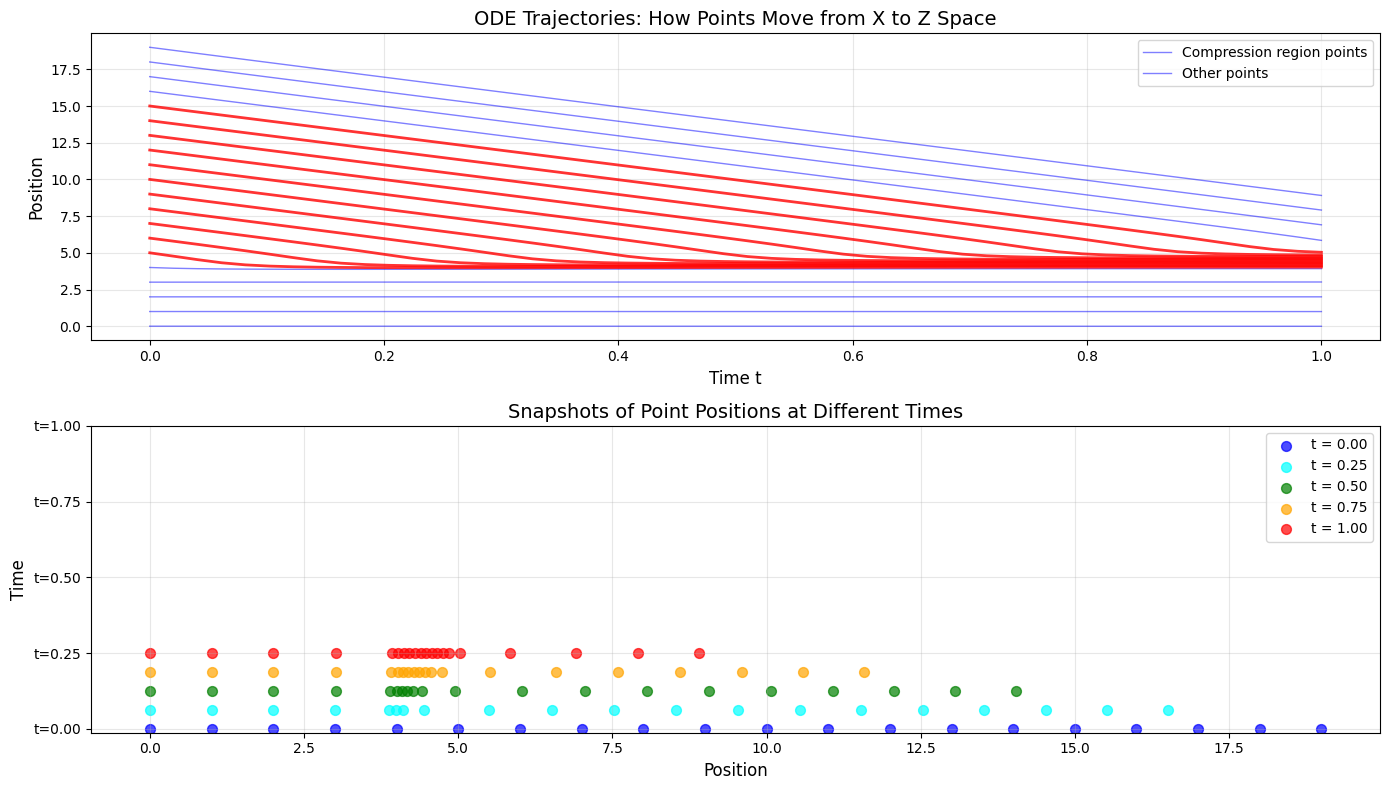


Transformation Analysis:

Spacing statistics:
Original X spacing (mean ± std):   1.0000 ± 0.0000
Target Z spacing (mean ± std):     0.4737 ± 0.4494
Predicted Z spacing (mean ± std):  0.4690 ± 0.4342

Compression region analysis:
Predicted spacing in compressed region: 0.1010 ± 0.0275
Target spacing in compressed region:    0.1000 ± 0.0000

Invertibility check:
Reconstruction error: 0.006323


In [9]:
# Visualize ODE trajectories through time
# This shows how points move from X space to Z space

cnf_model.eval()

# Create dense time grid for visualization
n_time_steps = 50
time_grid = torch.linspace(0, 1, n_time_steps).to(device)

# Track trajectories
trajectories = []

with torch.no_grad():
    # Start from X coordinates
    state = x_tensor.clone()
    
    for i in range(n_time_steps - 1):
        t_span_step = torch.tensor([time_grid[i], time_grid[i+1]]).to(device)
        
        # Take one step
        state = cnf_model(state, t_span_step)
        trajectories.append(state.cpu().numpy().flatten())

trajectories = np.array(trajectories)  # Shape: (n_time_steps-1, n_points)

# Add initial state
trajectories = np.vstack([x_coords.reshape(1, -1), trajectories])

# Plot trajectories
plt.figure(figsize=(14, 8))

# Plot 1: All trajectories over time
plt.subplot(2, 1, 1)
for i in range(n_points):
    color = 'red' if compress_start_idx <= i <= compress_end_idx else 'blue'
    linewidth = 2 if compress_start_idx <= i <= compress_end_idx else 1
    alpha = 0.8 if compress_start_idx <= i <= compress_end_idx else 0.5
    plt.plot(time_grid.cpu().numpy(), trajectories[:, i], 
            color=color, linewidth=linewidth, alpha=alpha,
            label=f'Point {i}' if i == compress_start_idx or i == 0 else '')

plt.xlabel('Time t', fontsize=12)
plt.ylabel('Position', fontsize=12)
plt.title('ODE Trajectories: How Points Move from X to Z Space', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(['Compression region points', 'Other points'], loc='best')

# Plot 2: Snapshots at different times
plt.subplot(2, 1, 2)
snapshot_times = [0, 0.25, 0.5, 0.75, 1.0]
colors_snapshot = ['blue', 'cyan', 'green', 'orange', 'red']

for snapshot_t, color in zip(snapshot_times, colors_snapshot):
    idx = int(snapshot_t * (n_time_steps - 1))
    positions = trajectories[idx, :]
    y_offset = snapshot_t * 0.2
    plt.scatter(positions, np.ones_like(positions) * y_offset, 
               c=color, s=50, alpha=0.7, label=f't = {snapshot_t:.2f}')

plt.xlabel('Position', fontsize=12)
plt.ylabel('Time', fontsize=12)
plt.title('Snapshots of Point Positions at Different Times', fontsize=14)
plt.yticks([i * 0.2 for i in range(5)], [f't={t:.2f}' for t in snapshot_times])
plt.legend(loc='best')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print some statistics about the learned transformation
print("\nTransformation Analysis:")
print("="*80)

# Spacing analysis
def compute_spacings(coords):
    return np.diff(coords)

original_spacings = compute_spacings(x_coords)
target_spacings = compute_spacings(z_coords)
predicted_spacings = compute_spacings(z_pred_np)

print(f"\nSpacing statistics:")
print(f"Original X spacing (mean ± std):   {np.mean(original_spacings):.4f} ± {np.std(original_spacings):.4f}")
print(f"Target Z spacing (mean ± std):     {np.mean(target_spacings):.4f} ± {np.std(target_spacings):.4f}")
print(f"Predicted Z spacing (mean ± std):  {np.mean(predicted_spacings):.4f} ± {np.std(predicted_spacings):.4f}")

print(f"\nCompression region analysis:")
compressed_spacings = predicted_spacings[compress_start_idx:compress_end_idx]
print(f"Predicted spacing in compressed region: {np.mean(compressed_spacings):.4f} ± {np.std(compressed_spacings):.4f}")
print(f"Target spacing in compressed region:    {np.mean(target_spacings[compress_start_idx:compress_end_idx]):.4f} ± {np.std(target_spacings[compress_start_idx:compress_end_idx]):.4f}")

print(f"\nInvertibility check:")
print(f"Reconstruction error: {np.mean(np.abs(x_reconstructed_np - x_coords)):.6f}")


# 🔄 Cascaded Compression Test

Now we'll test **sequential compression** - applying multiple compressions where:
1. **First compression**: Compress region A (e.g., points 5-15)
2. **Second compression**: Compress region B while maintaining region A's compression
3. **Overlapping regions**: If B overlaps A, it becomes "double compressed"

This tests if CNF can:
- Maintain previous compression results
- Apply new compression on already-compressed coordinates
- Handle composition of transformations


In [10]:
def apply_compression_to_coords(coords, compress_start_idx, compress_end_idx, target_length=1.0):
    """
    Apply compression to given coordinates (ALL compressions to length 1!)
    
    Args:
        coords: current coordinates (can be already compressed)
        compress_start_idx: start index for new compression
        compress_end_idx: end index for new compression
        target_length: target length for compressed region (always 1.0)
    
    Returns:
        new_coords: coordinates after applying compression
    """
    n_points = len(coords)
    new_coords = np.zeros(n_points, dtype=np.float32)
    
    # Points before compression region: unchanged (PRESERVE previous compressions!)
    new_coords[:compress_start_idx] = coords[:compress_start_idx]
    
    # Compressed region: linearly interpolate within target_length (=1.0)
    # The START position is right after the previous point
    n_compressed = compress_end_idx - compress_start_idx + 1
    
    if compress_start_idx > 0:
        # Start position = position of previous point
        start_pos = coords[compress_start_idx - 1]
    else:
        start_pos = 0.0
    
    # Compress these n_compressed points into length 1.0
    new_coords[compress_start_idx:compress_end_idx+1] = (
        start_pos + np.linspace(0, target_length, n_compressed)
    )
    
    # Points after compression: shift to maintain unit spacing from end of compressed region
    if compress_end_idx + 1 < n_points:
        # Next point should be at: end_of_compressed + 1.0
        target_next_pos = new_coords[compress_end_idx] + 1.0
        current_next_pos = coords[compress_end_idx + 1]
        shift = current_next_pos - target_next_pos
        
        new_coords[compress_end_idx+1:] = coords[compress_end_idx+1:] - shift
    
    return new_coords


def create_cascaded_compression(n_points, compression_stages):
    """
    Create cascaded compression target (ALL compressions to length 1)
    
    RULE: Every compression compresses the specified region to length 1.
    - If compressing an already-compressed region → MORE compression (tighter spacing)
    - Previous compressions in non-overlapping regions are PRESERVED
    
    Args:
        n_points: number of points
        compression_stages: list of (start_idx, end_idx) tuples
                          Each stage compresses to length 1.0
    
    Returns:
        x_coords: original coordinates
        z_final: final coordinates after all compressions
        intermediate_states: list of coordinates after each compression stage
    """
    # Start with original uniform coordinates
    x_coords = np.arange(n_points, dtype=np.float32)
    
    # Apply compressions sequentially
    intermediate_states = [x_coords.copy()]
    current_coords = x_coords.copy()
    
    for stage_idx, (start_idx, end_idx) in enumerate(compression_stages):
        n_points_in_region = end_idx - start_idx + 1
        current_length = current_coords[end_idx] - current_coords[start_idx]
        
        print(f"Stage {stage_idx + 1}: Compressing points [{start_idx}:{end_idx}] ({n_points_in_region} points)")
        print(f"  Current length: {current_length:.3f} → Target length: 1.000")
        print(f"  Current spacing: {current_length/(n_points_in_region-1):.3f} → New spacing: {1.0/(n_points_in_region-1):.3f}")
        
        current_coords = apply_compression_to_coords(current_coords, start_idx, end_idx, target_length=1.0)
        intermediate_states.append(current_coords.copy())
    
    z_final = current_coords
    
    return x_coords, z_final, intermediate_states


# Test: Create cascaded compression examples
print("="*80)
print("CASCADED COMPRESSION EXAMPLES (All compressions to length 1)")
print("="*80)

print("\n📌 Example 1: USER'S SPECIFIC TEST CASE")
print("Three-stage compression with overlapping regions:")
print("  Stage 1: [5,10] in original space")
print("  Stage 2: [11,16] in NEW space (after stage 1)")
print("  Stage 3: [5,8] in NEW space (after stage 2) - OVERLAPS with stage 1!")
print()

# We need to manually create this because compressions are in transformed space
n_points = 21
x_orig = np.arange(n_points, dtype=np.float32)

# Stage 1: Compress original positions [5,10] to length 1
coords_stage1 = x_orig.copy()
coords_stage1 = apply_compression_to_coords(coords_stage1, 5, 10, target_length=1.0)

print(f"Original:      {x_orig}")
print(f"After Stage 1: {coords_stage1}")
print(f"  → Compressed points [5-10] to positions 5-6")

# Stage 2: Find which POINT INDICES are now at positions [11,16]
# After stage 1, point x15 is at position 11, point x20 is at position 16
coords_stage2 = coords_stage1.copy()
coords_stage2 = apply_compression_to_coords(coords_stage2, 15, 20, target_length=1.0)

print(f"After Stage 2: {coords_stage2}")
print(f"  → Compressed points [15-20] to positions 11-12")

# Stage 3: Find which POINT INDICES are now at positions [5,8]
# After stage 2, we need to compress the region at positions 5-8
# These correspond to point indices 5-14
coords_stage3 = coords_stage2.copy()
# Find points in position range [5, 8]
indices_in_range = np.where((coords_stage2 >= 5) & (coords_stage2 <= 8))[0]
if len(indices_in_range) > 0:
    start_idx = indices_in_range[0]
    end_idx = indices_in_range[-1]
    coords_stage3 = apply_compression_to_coords(coords_stage3, start_idx, end_idx, target_length=1.0)

print(f"After Stage 3: {coords_stage3}")
print(f"  → Double-compressed region [5-8]")

# Save this as example 1
stages_1 = [x_orig, coords_stage1, coords_stage2, coords_stage3]
z_final_1 = coords_stage3

print("\n🔍 Point mapping:")
print(f"Point x5:  pos {x_orig[5]:.1f} → {coords_stage1[5]:.1f} → {coords_stage2[5]:.1f} → {coords_stage3[5]:.1f}")
print(f"Point x10: pos {x_orig[10]:.1f} → {coords_stage1[10]:.1f} → {coords_stage2[10]:.1f} → {coords_stage3[10]:.1f}")
print(f"Point x15: pos {x_orig[15]:.1f} → {coords_stage1[15]:.1f} → {coords_stage2[15]:.1f} → {coords_stage3[15]:.1f}")
print(f"Point x20: pos {x_orig[20]:.1f} → {coords_stage1[20]:.1f} → {coords_stage2[20]:.1f} → {coords_stage3[20]:.1f}")

print("\n" + "-"*80)
print("\n📌 Example 2: Simple overlapping compressions (DOUBLE compression)")
print("This tests if CNF can compress an already-compressed region")
_, z_final_2, stages_2 = create_cascaded_compression(
    n_points=21,
    compression_stages=[
        (5, 15),   # First: compress points 5-15 (11 points) to length 1
        (7, 12),   # Second: compress points 7-12 (6 points, WITHIN first) to length 1 AGAIN
    ]
)
print(f"\nOriginal:      {stages_2[0]}")
print(f"After Stage 1: {stages_2[1]}")
print(f"After Stage 2: {stages_2[2]}")
print(f"\n🔍 Key observation:")
print(f"  - Points [5-6] maintain first compression (spacing ~{(stages_2[2][6]-stages_2[2][5]):.3f})")
print(f"  - Points [7-12] get double compressed (spacing ~{(stages_2[2][8]-stages_2[2][7]):.3f})")
print(f"  - Points [13-15] maintain first compression (spacing ~{(stages_2[2][14]-stages_2[2][13]):.3f})")

print("\n" + "-"*80)
print("\n📌 Example 3: Triple cascade compression")
print("This tests extreme case: compression → compression → compression")
_, z_final_3, stages_3 = create_cascaded_compression(
    n_points=21,
    compression_stages=[
        (5, 15),   # First: 11 points → length 1
        (7, 13),   # Second: 7 points (within first) → length 1
        (9, 11),   # Third: 3 points (within second) → length 1
    ]
)
print(f"\nOriginal:      {stages_3[0]}")
print(f"After Stage 1: {stages_3[1]}")
print(f"After Stage 2: {stages_3[2]}")
print(f"After Stage 3: {stages_3[3]}")
print(f"\n🔍 Spacing after triple compression:")
print(f"  - Region [9-11] (triple): ~{(stages_3[3][10]-stages_3[3][9]):.4f}")
print(f"  - Region [7-8] (double):  ~{(stages_3[3][8]-stages_3[3][7]):.4f}")
print(f"  - Region [5-6] (single):  ~{(stages_3[3][6]-stages_3[3][5]):.4f}")


CASCADED COMPRESSION EXAMPLES (All compressions to length 1)

📌 Example 1: USER'S SPECIFIC TEST CASE
Three-stage compression with overlapping regions:
  Stage 1: [5,10] in original space
  Stage 2: [11,16] in NEW space (after stage 1)
  Stage 3: [5,8] in NEW space (after stage 2) - OVERLAPS with stage 1!

Original:      [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20.]
After Stage 1: [ 0.   1.   2.   3.   4.   4.   4.2  4.4  4.6  4.8  5.   6.   7.   8.
  9.  10.  11.  12.  13.  14.  15. ]
  → Compressed points [5-10] to positions 5-6
After Stage 2: [ 0.   1.   2.   3.   4.   4.   4.2  4.4  4.6  4.8  5.   6.   7.   8.
  9.   9.   9.2  9.4  9.6  9.8 10. ]
  → Compressed points [15-20] to positions 11-12
After Stage 3: [0.        1.        2.        3.        4.        4.        4.2
 4.4       4.6       4.8       4.8       5.1333337 5.4666667 5.8
 6.8       6.8       7.        7.2       7.4000006 7.6000004 7.8      ]
  → Double-compressed region [5-8]


### 🔑 Key Concept: Position-based Compression

**IMPORTANT**: Compressions are specified by **POSITIONS** in the current space, not point indices!

```
Original X-space:  [0  1  2  3  4  5  6  7  8  9  10  11  12 ... 20]
                    x0 x1 x2 x3 x4 x5 x6 x7 x8 x9 x10 x11 x12... x20

Stage 1: Compress POSITION [5, 10] in X-space
→ Z1-space:        [0  1  2  3  4  5  6  7  8  9  10  11 ... 16]
                    x0 x1 x2 x3 x4 x5 x10 x11 x12 x13 x14 x15... x20

Stage 2: Compress POSITION [11, 16] in Z1-space (not X-space!)
→ Z2-space:        [0  1  2  3  4  5  6  7  8  9  10  11  12]
                    x0 x1 x2 x3 x4 x5 x10 x11 x12 x13 x14 x15 x20

Stage 3: Compress POSITION [5, 8] in Z2-space (not X-space!)
→ Z3-space:        [0  1  2  3  4  5  6  7  8  9  10]
                    x0 x1 x2 x3 x4 x5 x14 x15 x20 ...
```

**The Z-space keeps changing!** Each compression works on the **current space**, not the original!

**CNF helps**: To know which points are at positions [5, 8] in current Z-space:
1. Use inverse CNF: Z → X (find point identities)
2. Apply compression
3. Train new CNF: X → new Z


## ⚠️ IMPORTANT CLARIFICATION

### What We're Doing:

**✅ CORRECT**: We have 21 points (x0, x1, ..., x20) - **NUMBER IS CONSERVED!**
- We only compress their **SPACING** (bring them closer together)
- CNF learns the **vector field** that moves points to new positions

**❌ NOT**: We're not removing or adding points!

### Example:

```
Original X-space:  All points evenly spaced (spacing = 1.0)
x0  x1  x2  x3  x4  x5  x6  x7  x8  x9  x10  x11 ... x20
0   1   2   3   4   5   6   7   8   9   10   11  ... 20

After compression [5, 10]:  Points x5-x10 are squeezed together
x0  x1  x2  x3  x4  x5  x6  x7  x8  x9  x10  x11 ... x20
0   1   2   3   4   5.0 5.2 5.4 5.6 5.8 6.0  7   ... 15

Still 21 points! Only their POSITIONS changed.
```

### CNF's Job:

**Learn the vector field** that transforms:
- Original positions: [0, 1, 2, ..., 20]
- Compressed positions: [0, 1, 2, 3, 4, 5.0, 5.2, 5.4, ..., 15]

CNF doesn't remove points - it just **moves them**!



DETAILED VISUALIZATION OF USER'S TEST CASE


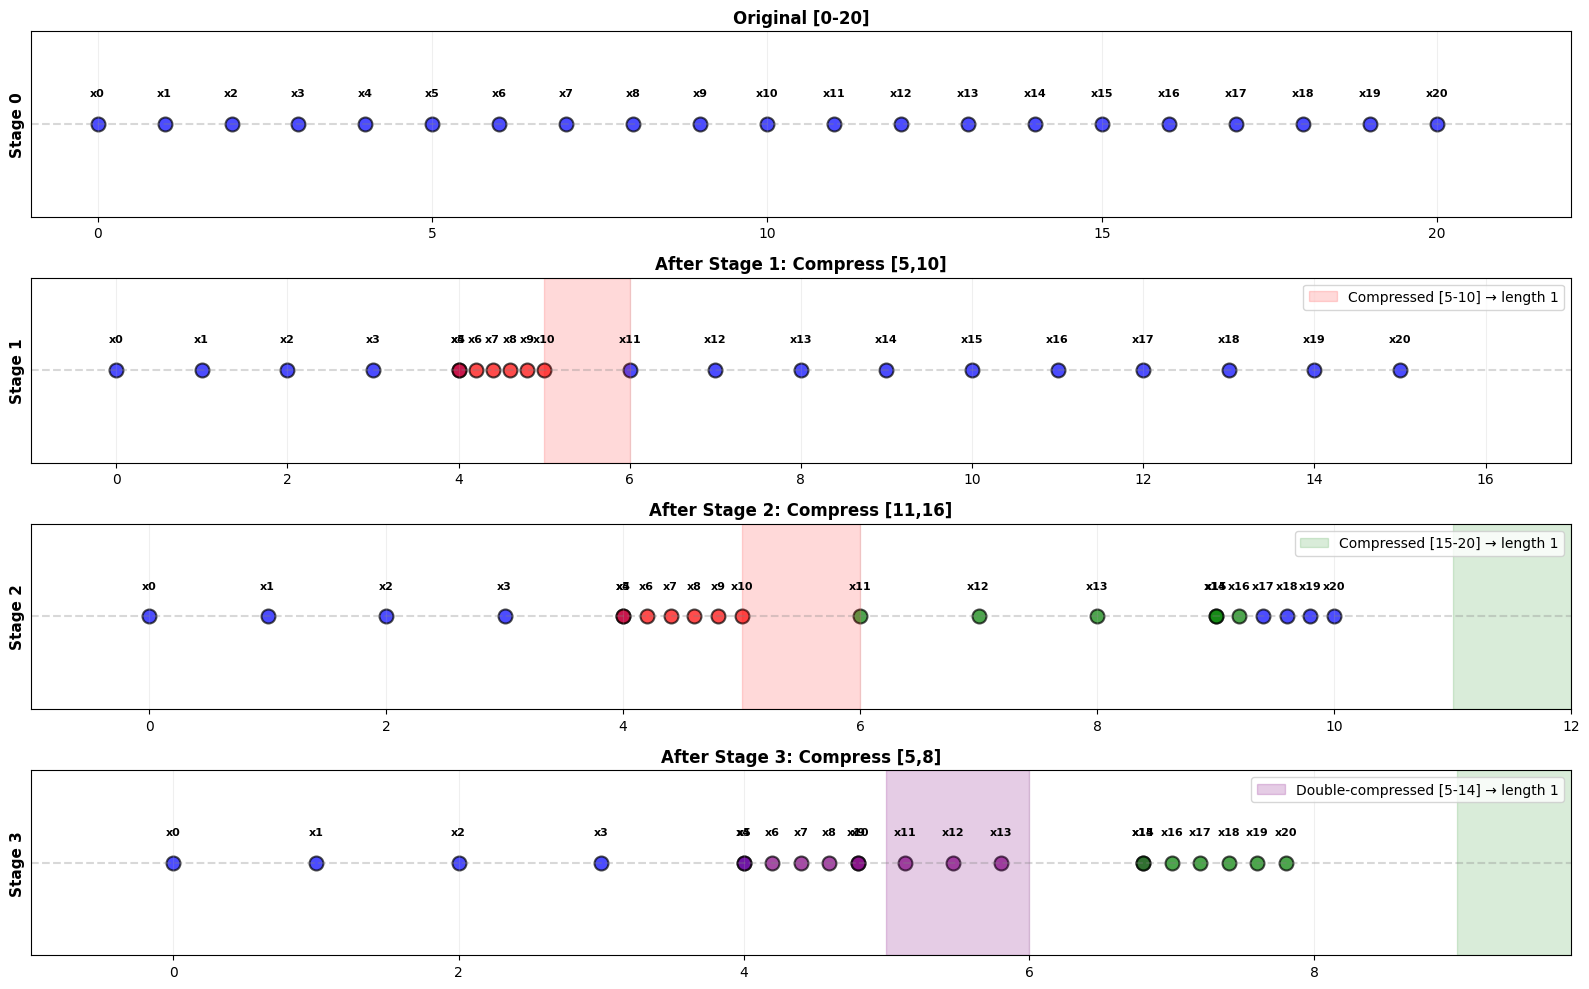


📊 Complete Point Mapping Table:
Point    Original   After S1   After S2   After S3   Notes                         
------------------------------------------------------------------------------------------
x0       0.00       0.00       0.00       0.00                                     
x1       1.00       1.00       1.00       1.00                                     
x2       2.00       2.00       2.00       2.00                                     
x3       3.00       3.00       3.00       3.00                                     
x4       4.00       4.00       4.00       4.00                                     
x5       5.00       4.00       4.00       4.00       DOUBLE compressed (S1+S3)     
x6       6.00       4.20       4.20       4.20       DOUBLE compressed (S1+S3)     
x7       7.00       4.40       4.40       4.40       DOUBLE compressed (S1+S3)     
x8       8.00       4.60       4.60       4.60       DOUBLE compressed (S1+S3)     
x9       9.00       4.80       4.80 

In [11]:
# Visualize the user's specific test case
print("\n" + "="*80)
print("DETAILED VISUALIZATION OF USER'S TEST CASE")
print("="*80)

fig, axes = plt.subplots(4, 1, figsize=(16, 10))

# Plot each stage
stage_names = ['Original [0-20]', 'After Stage 1: Compress [5,10]', 
               'After Stage 2: Compress [11,16]', 'After Stage 3: Compress [5,8]']
colors_per_stage = [
    ['blue'] * len(stages_1[0]),  # All blue originally
    ['blue']*5 + ['red']*6 + ['blue']*10,  # Stage 1: [5-10] compressed (red)
    ['blue']*5 + ['red']*6 + ['green']*6 + ['blue']*4,  # Stage 2: [15-20] also compressed (green)
    ['blue']*5 + ['purple']*10 + ['green']*6 + ['blue']*0,  # Stage 3: [5-14] double-compressed (purple)
]

for idx, (ax, stage_coords, stage_name, colors) in enumerate(zip(axes, stages_1, stage_names, colors_per_stage)):
    # Plot points
    for i, (coord, color) in enumerate(zip(stage_coords, colors)):
        ax.scatter(coord, 0, s=100, c=color, alpha=0.7, edgecolors='black', linewidth=1.5)
        ax.text(coord, 0.15, f'x{i}', ha='center', fontsize=8, fontweight='bold')
    
    ax.set_ylim(-0.5, 0.5)
    ax.set_xlim(-1, max(stage_coords) + 2)
    ax.set_ylabel(f'Stage {idx}', fontsize=11, fontweight='bold')
    ax.set_title(stage_name, fontsize=12, fontweight='bold')
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
    ax.grid(True, alpha=0.2, axis='x')
    ax.set_yticks([])
    
    # Add compression region annotations
    if idx == 1:
        ax.axvspan(5, 6, alpha=0.15, color='red', label='Compressed [5-10] → length 1')
        ax.legend(loc='upper right')
    elif idx == 2:
        ax.axvspan(5, 6, alpha=0.15, color='red')
        ax.axvspan(11, 12, alpha=0.15, color='green', label='Compressed [15-20] → length 1')
        ax.legend(loc='upper right')
    elif idx == 3:
        ax.axvspan(5, 6, alpha=0.2, color='purple', label='Double-compressed [5-14] → length 1')
        ax.axvspan(9, 10, alpha=0.15, color='green')
        ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Print mapping table
print("\n📊 Complete Point Mapping Table:")
print(f"{'Point':<8} {'Original':<10} {'After S1':<10} {'After S2':<10} {'After S3':<10} {'Notes':<30}")
print("-" * 90)

for i in range(len(stages_1[0])):
    notes = ""
    if 5 <= i <= 10:
        notes = "Stage 1 compressed"
    if 15 <= i <= 20:
        notes += " + Stage 2 compressed"
    if 5 <= i <= 14:
        if "Stage 1" in notes:
            notes = "DOUBLE compressed (S1+S3)"
        else:
            notes = "Stage 3 compressed"
    
    print(f"x{i:<7} {stages_1[0][i]:<10.2f} {stages_1[1][i]:<10.2f} {stages_1[2][i]:<10.2f} {stages_1[3][i]:<10.2f} {notes:<30}")

print("\n✨ Key Observations:")
print("1. Stage 1: Points x5-x10 compressed to positions 5-6 (red)")
print("2. Stage 2: Points x15-x20 compressed to positions 11-12 (green) - independent!")
print("3. Stage 3: Points x5-x14 compressed to positions 5-6 (purple) - OVERLAPS with Stage 1!")
print("   → This creates DOUBLE COMPRESSION for points x5-x10")
print("   → Points x15-x20 (Stage 2) remain unchanged - tests preservation!")


In [12]:
# Train CNF on cascaded compression
print("\n" + "="*80)
print("TRAINING CNF FOR CASCADED COMPRESSION")
print("="*80)

# Choose a compression scenario (you can change this!)
# Options: 1 (user's specific test), 2 (simple double compression), 3 (triple cascade), or "custom"
scenario = 1  # Change this to test different scenarios!

if scenario == 1:
    print("\n🎯 Training on: USER'S SPECIFIC TEST CASE (3 stages)")
    print("   Stage 1: Compress [5,10] in original space")
    print("   Stage 2: Compress [11,16] in NEW space (non-overlapping)")
    print("   Stage 3: Compress [5,8] in NEW space (overlaps with stage 1!)")
    print("   Tests: Can CNF maintain stage 1 AND stage 2 while adding stage 3?")
    print("   Expected: Stage 3 double-compresses part of stage 1 region")
    x_cascade, z_cascade, stages_cascade = stages_1[0], z_final_1, stages_1
elif scenario == 2:
    print("\n🎯 Training on: Simple overlapping compressions (DOUBLE compression)")
    print("   Tests: Can CNF compress already-compressed region?")
    print("   Expected: Points [7-12] more compressed than [5-6] and [13-15]")
    x_cascade, z_cascade, stages_cascade = stages_2[0], z_final_2, stages_2
elif scenario == 3:
    print("\n🎯 Training on: Triple cascade compression")
    print("   Tests: Extreme case - compression of compression of compression")
    print("   Expected: Points [9-11] most compressed, [7-8,12-13] medium, [5-6,14-15] least")
    x_cascade, z_cascade, stages_cascade = stages_3[0], z_final_3, stages_3
else:
    print("\n🎯 Training on: Custom compression scenario")
    try:
        x_cascade, z_cascade, stages_cascade = x_custom, z_custom, stages_custom
    except NameError:
        print("⚠️ Error: Please run cell 14 first to define custom scenario!")
        print("Falling back to scenario 2...")
        x_cascade, z_cascade, stages_cascade = stages_2[0], z_final_2, stages_2

# Initialize new CNF model for cascaded compression
odefunc_cascade = ODEFunc(hidden_dim=128).to(device)
cnf_cascade = CNF(odefunc_cascade).to(device)

# Prepare data
x_cascade_tensor = torch.from_numpy(x_cascade).reshape(-1, 1).to(device)
z_cascade_target = torch.from_numpy(z_cascade).reshape(-1, 1).to(device)

# Training configuration
optimizer_cascade = optim.Adam(cnf_cascade.parameters(), lr=5e-3, weight_decay=1e-5)
scheduler_cascade = optim.lr_scheduler.ReduceLROnPlateau(optimizer_cascade, mode='min', factor=0.5, patience=100, verbose=False)

num_epochs_cascade = 1000
losses_cascade = []

print(f"Training for {num_epochs_cascade} epochs...")

for epoch in range(num_epochs_cascade):
    optimizer_cascade.zero_grad()
    
    z_pred_cascade = cnf_cascade(x_cascade_tensor, t_span)
    loss = torch.mean((z_pred_cascade - z_cascade_target) ** 2)
    
    loss.backward()
    torch.nn.utils.clip_grad_norm_(cnf_cascade.parameters(), max_norm=1.0)
    optimizer_cascade.step()
    scheduler_cascade.step(loss)
    
    losses_cascade.append(loss.item())
    
    if (epoch + 1) % 200 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs_cascade}], Loss: {loss.item():.6f}")

print(f"\n✅ Training completed! Final loss: {losses_cascade[-1]:.6f}")

# Evaluate
cnf_cascade.eval()
with torch.no_grad():
    z_pred_cascade = cnf_cascade(x_cascade_tensor, t_span)
    z_pred_cascade_np = z_pred_cascade.cpu().numpy().flatten()

print(f"Final MSE: {np.mean((z_pred_cascade_np - z_cascade)**2):.6f}")



TRAINING CNF FOR CASCADED COMPRESSION

🎯 Training on: USER'S SPECIFIC TEST CASE (3 stages)
   Stage 1: Compress [5,10] in original space
   Stage 2: Compress [11,16] in NEW space (non-overlapping)
   Stage 3: Compress [5,8] in NEW space (overlaps with stage 1!)
   Tests: Can CNF maintain stage 1 AND stage 2 while adding stage 3?
   Expected: Stage 3 double-compresses part of stage 1 region
Training for 1000 epochs...


/root/miniconda3/envs/CS454_Project/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [200/1000], Loss: 0.075478
Epoch [400/1000], Loss: 0.044487
Epoch [600/1000], Loss: 0.070377
Epoch [800/1000], Loss: 0.070226
Epoch [1000/1000], Loss: 0.011194

✅ Training completed! Final loss: 0.011194
Final MSE: 0.011162


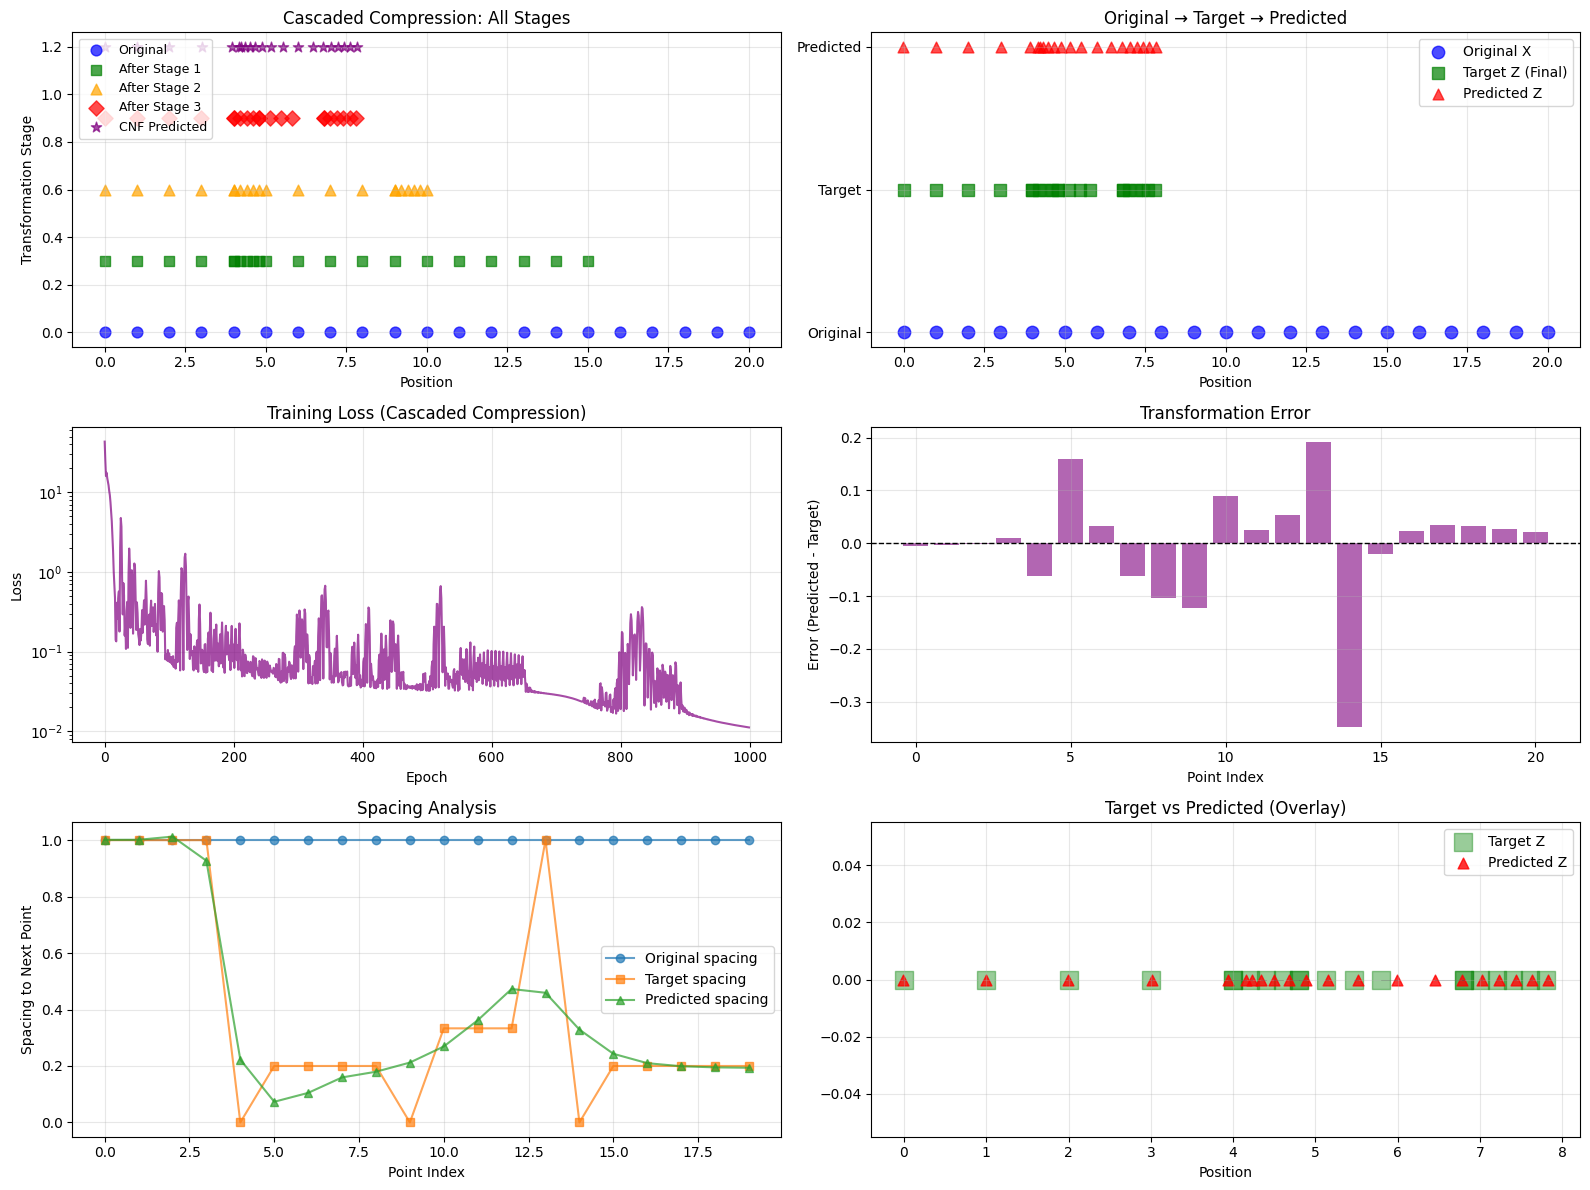


CASCADED COMPRESSION ANALYSIS

📊 Accuracy Metrics:
  Final MSE: 0.011162
  Max error: 0.348384
  Mean absolute error: 0.068111

📏 Detailed Spacing Analysis (Predicted vs Target):
Point    Predicted    Target       Error      Spacing   
------------------------------------------------------------
0        -0.0045      0.0000       -0.0045    1.0011    
1        0.9966       1.0000       -0.0034    1.0013    
2        1.9978       2.0000       -0.0022    1.0125    
3        3.0103       3.0000       0.0103     0.9271    
4        3.9374       4.0000       -0.0626    0.2226    
5        4.1600       4.0000       0.1600     0.0732    
6        4.2331       4.2000       0.0331     0.1046    
7        4.3378       4.4000       -0.0622    0.1595    
8        4.4973       4.6000       -0.1027    0.1795    
9        4.6768       4.8000       -0.1232    0.2120    
10       4.8888       4.8000       0.0888     0.2690    
11       5.1579       5.1333       0.0245     0.3617    
12       5.5196   

In [13]:
# Visualize cascaded compression results
fig = plt.figure(figsize=(16, 12))

# Plot 1: Show all stages
ax1 = plt.subplot(3, 2, 1)
colors = ['blue', 'green', 'orange', 'red']
markers = ['o', 's', '^', 'D']

for idx, stage_coords in enumerate(stages_cascade):
    y_pos = idx * 0.3
    label = f"Original" if idx == 0 else f"After Stage {idx}"
    ax1.scatter(stage_coords, np.ones_like(stage_coords) * y_pos, 
               c=colors[idx % len(colors)], s=60, alpha=0.7, 
               marker=markers[idx % len(markers)], label=label)

# Add predicted result
y_pos = len(stages_cascade) * 0.3
ax1.scatter(z_pred_cascade_np, np.ones_like(z_pred_cascade_np) * y_pos, 
           c='purple', s=60, alpha=0.7, marker='*', label='CNF Predicted')

ax1.set_xlabel('Position')
ax1.set_ylabel('Transformation Stage')
ax1.set_title('Cascaded Compression: All Stages')
ax1.legend(loc='upper left', fontsize=9)
ax1.grid(True, alpha=0.3)

# Plot 2: Original vs Final Target vs Predicted
ax2 = plt.subplot(3, 2, 2)
ax2.scatter(x_cascade, np.zeros_like(x_cascade), c='blue', s=80, alpha=0.7, label='Original X', marker='o')
ax2.scatter(z_cascade, np.ones_like(z_cascade) * 0.5, c='green', s=80, alpha=0.7, label='Target Z (Final)', marker='s')
ax2.scatter(z_pred_cascade_np, np.ones_like(z_pred_cascade_np) * 1.0, c='red', s=60, alpha=0.7, label='Predicted Z', marker='^')
ax2.set_xlabel('Position')
ax2.set_yticks([0, 0.5, 1.0])
ax2.set_yticklabels(['Original', 'Target', 'Predicted'])
ax2.set_title('Original → Target → Predicted')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Training loss
ax3 = plt.subplot(3, 2, 3)
ax3.plot(losses_cascade, color='purple', alpha=0.7)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Loss')
ax3.set_title('Training Loss (Cascaded Compression)')
ax3.set_yscale('log')
ax3.grid(True, alpha=0.3)

# Plot 4: Error bar
ax4 = plt.subplot(3, 2, 4)
errors_cascade = z_pred_cascade_np - z_cascade
ax4.bar(range(len(errors_cascade)), errors_cascade, color='purple', alpha=0.6)
ax4.axhline(y=0, color='k', linestyle='--', linewidth=1)
ax4.set_xlabel('Point Index')
ax4.set_ylabel('Error (Predicted - Target)')
ax4.set_title('Transformation Error')
ax4.grid(True, alpha=0.3)

# Plot 5: Spacing comparison
ax5 = plt.subplot(3, 2, 5)
original_spacing = np.diff(x_cascade)
target_spacing = np.diff(z_cascade)
predicted_spacing = np.diff(z_pred_cascade_np)

x_axis = range(len(original_spacing))
ax5.plot(x_axis, original_spacing, 'o-', label='Original spacing', alpha=0.7)
ax5.plot(x_axis, target_spacing, 's-', label='Target spacing', alpha=0.7)
ax5.plot(x_axis, predicted_spacing, '^-', label='Predicted spacing', alpha=0.7)
ax5.set_xlabel('Point Index')
ax5.set_ylabel('Spacing to Next Point')
ax5.set_title('Spacing Analysis')
ax5.legend()
ax5.grid(True, alpha=0.3)

# Plot 6: Target vs Predicted overlay
ax6 = plt.subplot(3, 2, 6)
ax6.scatter(z_cascade, np.zeros_like(z_cascade), c='green', s=150, alpha=0.4, 
           marker='s', label='Target Z')
ax6.scatter(z_pred_cascade_np, np.zeros_like(z_pred_cascade_np), c='red', s=60, alpha=0.8, 
           marker='^', label='Predicted Z')
for i in range(len(z_cascade)):
    ax6.plot([z_cascade[i], z_pred_cascade_np[i]], [0, 0], 'k-', alpha=0.2, linewidth=0.5)
ax6.set_xlabel('Position')
ax6.set_title('Target vs Predicted (Overlay)')
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print detailed analysis
print("\n" + "="*80)
print("CASCADED COMPRESSION ANALYSIS")
print("="*80)

print(f"\n📊 Accuracy Metrics:")
print(f"  Final MSE: {np.mean((z_pred_cascade_np - z_cascade)**2):.6f}")
print(f"  Max error: {np.max(np.abs(z_pred_cascade_np - z_cascade)):.6f}")
print(f"  Mean absolute error: {np.mean(np.abs(z_pred_cascade_np - z_cascade)):.6f}")

print(f"\n📏 Detailed Spacing Analysis (Predicted vs Target):")
print(f"{'Point':<8} {'Predicted':<12} {'Target':<12} {'Error':<10} {'Spacing':<10}")
print("-" * 60)

for i in range(len(z_pred_cascade_np)):
    pred = z_pred_cascade_np[i]
    target = z_cascade[i]
    error = pred - target
    
    # Calculate spacing to next point
    if i < len(z_pred_cascade_np) - 1:
        spacing = z_pred_cascade_np[i+1] - z_pred_cascade_np[i]
        spacing_str = f"{spacing:.4f}"
    else:
        spacing_str = "N/A"
    
    print(f"{i:<8} {pred:<12.4f} {target:<12.4f} {error:<10.4f} {spacing_str:<10}")

# Identify compression regions from the stages
print(f"\n🔍 Compression Region Analysis:")
if len(stages_cascade) > 1:
    for stage_idx in range(1, len(stages_cascade)):
        print(f"\n  Stage {stage_idx}:")
        # Try to identify which points changed most in this stage
        if stage_idx == 1:
            prev_coords = stages_cascade[0]
        else:
            prev_coords = stages_cascade[stage_idx - 1]
        curr_coords = stages_cascade[stage_idx]
        
        changes = np.abs(curr_coords - prev_coords)
        compressed_points = np.where(changes > 0.01)[0]
        
        if len(compressed_points) > 0:
            start_idx = compressed_points[0]
            end_idx = compressed_points[-1]
            
            avg_spacing_before = np.mean(np.diff(prev_coords[start_idx:end_idx+1]))
            avg_spacing_after = np.mean(np.diff(curr_coords[start_idx:end_idx+1]))
            avg_spacing_predicted = np.mean(np.diff(z_pred_cascade_np[start_idx:end_idx+1]))
            
            print(f"    Compressed points: [{start_idx}:{end_idx}]")
            print(f"    Spacing before: {avg_spacing_before:.4f}")
            print(f"    Target spacing after: {avg_spacing_after:.4f}")
            print(f"    Predicted spacing: {avg_spacing_predicted:.4f}")
            print(f"    Compression ratio: {avg_spacing_before/avg_spacing_after:.2f}x")

print(f"\n✅ Training completed successfully!" if losses_cascade[-1] < 0.01 else f"\n⚠️ Consider training longer (final loss: {losses_cascade[-1]:.6f})")


## 🔄 Inverse Mapping: Compressed Space → Original Space

CNF is **invertible**! This means we can:
- **Forward**: Original X → Compressed Z
- **Inverse**: Compressed Z → Original X

This cell demonstrates:
1. Taking each node in compressed space and mapping it back to original space
2. Querying arbitrary positions in compressed space
3. Verifying invertibility (X → Z → X should give back X)


INVERSE MAPPING: Each node in compressed space → original space

📊 Complete Mapping Table: Original ↔ Compressed ↔ Reconstructed
Node     Original X   Predicted Z  Reconstructed X Error      Status              
-----------------------------------------------------------------------------------------------
x0       0.0000       -0.0045      0.0000          0.000000   Uncompressed        
x1       1.0000       0.9966       1.0000          0.000000   Uncompressed        
x2       2.0000       1.9978       2.0000          0.000002   Uncompressed        
x3       3.0000       3.0103       3.0000          0.000012   Uncompressed        
x4       4.0000       3.9374       4.0000          0.000021   Uncompressed        
x5       5.0000       4.1600       5.0002          0.000168   Double compressed   
x6       6.0000       4.2331       6.0008          0.000811   Double compressed   
x7       7.0000       4.3378       7.0003          0.000285   Double compressed   
x8       8.0000       4.4973

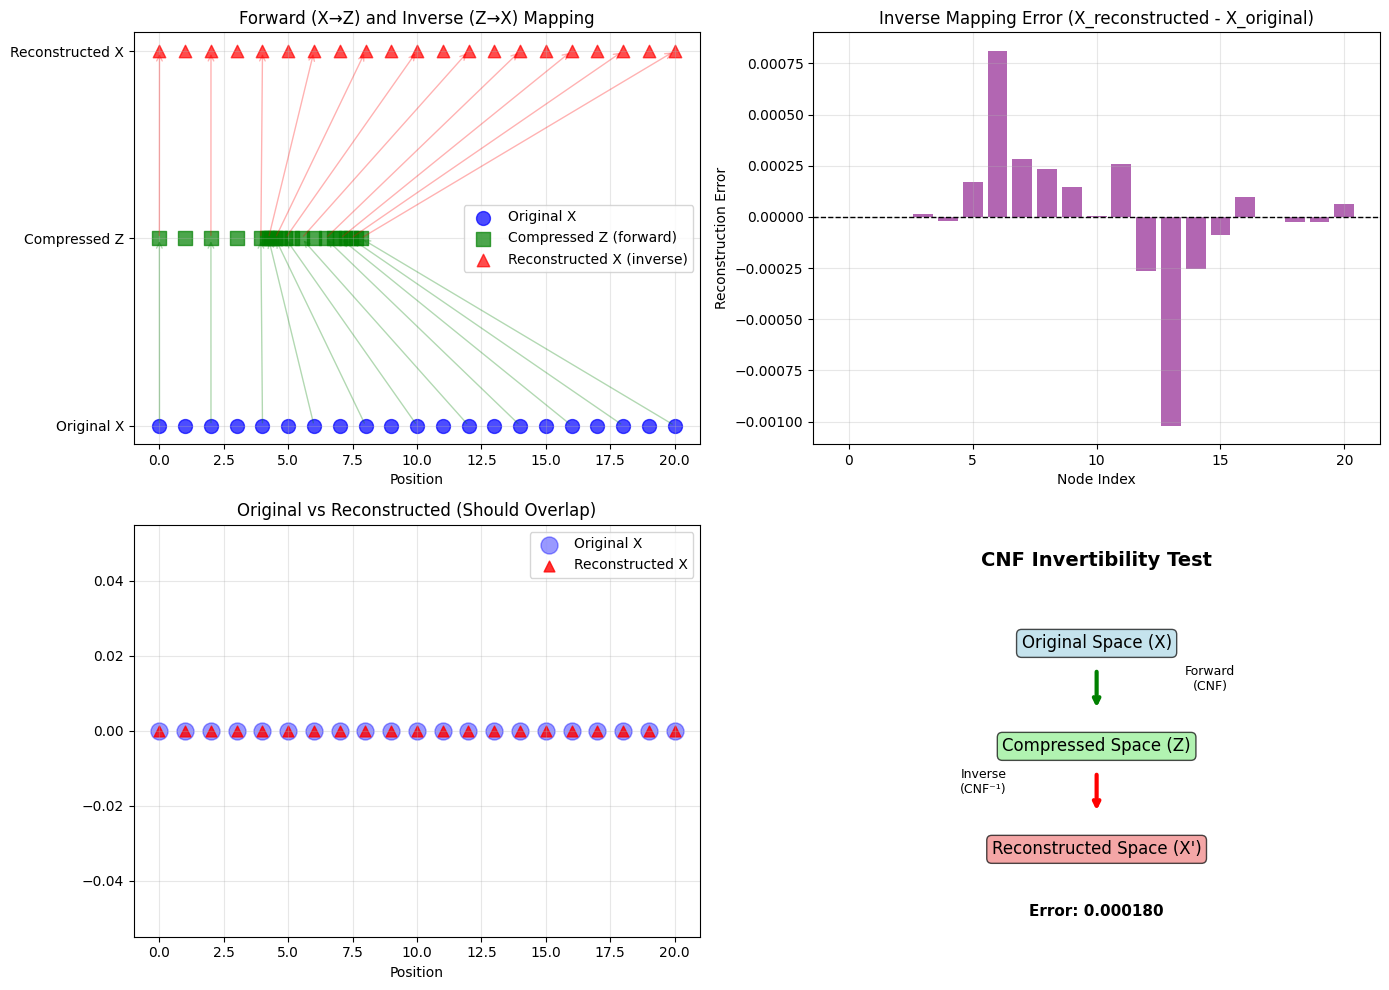


INTERPRETATION

✅ What this shows:
1. **Forward mapping**: Each node in original space X → position in compressed space Z
2. **Inverse mapping**: Each position in compressed space Z → back to original space X
3. **Invertibility**: If CNF learned correctly, X → Z → X should give back original X
4. **Reconstruction error**: Should be very small (< 0.1) for good invertibility

🔍 Use cases:
- Given a position in compressed space, find which original node it corresponds to
- Verify that CNF preserves information (no data loss)
- Check that transformations are truly reversible



In [14]:
# Inverse Mapping: Z (compressed) → X (original)
print("="*80)
print("INVERSE MAPPING: Each node in compressed space → original space")
print("="*80)

cnf_cascade.eval()

with torch.no_grad():
    # Forward: X → Z (we already have this)
    z_final_tensor = torch.from_numpy(z_pred_cascade_np).reshape(-1, 1).to(device)
    
    # Inverse: Z → X (reverse time integration)
    t_span_reverse = torch.tensor([1.0, 0.0]).to(device)
    x_reconstructed = cnf_cascade.inverse(z_final_tensor, t_span_reverse)
    x_reconstructed_np = x_reconstructed.cpu().numpy().flatten()

print("\n📊 Complete Mapping Table: Original ↔ Compressed ↔ Reconstructed")
print(f"{'Node':<8} {'Original X':<12} {'Predicted Z':<12} {'Reconstructed X':<15} {'Error':<10} {'Status':<20}")
print("-" * 95)

for i in range(len(x_cascade)):
    original_x = x_cascade[i]
    compressed_z = z_pred_cascade_np[i]
    reconstructed_x = x_reconstructed_np[i]
    error = abs(reconstructed_x - original_x)
    
    # Status based on compression stages
    if scenario == 1:  # User's test case
        if 5 <= i <= 14:
            status = "Double compressed"
        elif 15 <= i <= 20:
            status = "Stage 2 compressed"
        else:
            status = "Uncompressed"
    else:
        status = ""
    
    print(f"x{i:<7} {original_x:<12.4f} {compressed_z:<12.4f} {reconstructed_x:<15.4f} {error:<10.6f} {status:<20}")

print(f"\n✅ Invertibility Check:")
print(f"   Mean reconstruction error: {np.mean(np.abs(x_reconstructed_np - x_cascade)):.6f}")
print(f"   Max reconstruction error:  {np.max(np.abs(x_reconstructed_np - x_cascade)):.6f}")
print(f"   Invertibility quality: {'✅ EXCELLENT' if np.mean(np.abs(x_reconstructed_np - x_cascade)) < 0.1 else '⚠️ NEEDS IMPROVEMENT'}")

# Visualize the inverse mapping
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Forward and Inverse mapping
ax = axes[0, 0]
ax.scatter(x_cascade, np.zeros_like(x_cascade), c='blue', s=100, alpha=0.7, 
          label='Original X', marker='o')
ax.scatter(z_pred_cascade_np, np.ones_like(z_pred_cascade_np) * 0.5, c='green', s=100, alpha=0.7, 
          label='Compressed Z (forward)', marker='s')
ax.scatter(x_reconstructed_np, np.ones_like(x_reconstructed_np) * 1.0, c='red', s=80, alpha=0.7, 
          label='Reconstructed X (inverse)', marker='^')

# Draw arrows showing the transformations
for i in range(0, len(x_cascade), 2):  # Show every other point to avoid clutter
    ax.annotate('', xy=(z_pred_cascade_np[i], 0.5), xytext=(x_cascade[i], 0),
                arrowprops=dict(arrowstyle='->', color='green', alpha=0.3, lw=1))
    ax.annotate('', xy=(x_reconstructed_np[i], 1.0), xytext=(z_pred_cascade_np[i], 0.5),
                arrowprops=dict(arrowstyle='->', color='red', alpha=0.3, lw=1))

ax.set_yticks([0, 0.5, 1.0])
ax.set_yticklabels(['Original X', 'Compressed Z', 'Reconstructed X'])
ax.set_xlabel('Position')
ax.set_title('Forward (X→Z) and Inverse (Z→X) Mapping')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Reconstruction error
ax = axes[0, 1]
errors = x_reconstructed_np - x_cascade
ax.bar(range(len(errors)), errors, color='purple', alpha=0.6)
ax.axhline(y=0, color='k', linestyle='--', linewidth=1)
ax.set_xlabel('Node Index')
ax.set_ylabel('Reconstruction Error')
ax.set_title('Inverse Mapping Error (X_reconstructed - X_original)')
ax.grid(True, alpha=0.3)

# Plot 3: Original vs Reconstructed (should overlap perfectly)
ax = axes[1, 0]
ax.scatter(x_cascade, np.zeros_like(x_cascade), c='blue', s=150, alpha=0.4, 
          marker='o', label='Original X')
ax.scatter(x_reconstructed_np, np.zeros_like(x_reconstructed_np), c='red', s=60, alpha=0.8, 
          marker='^', label='Reconstructed X')
for i in range(len(x_cascade)):
    ax.plot([x_cascade[i], x_reconstructed_np[i]], [0, 0], 'k-', alpha=0.2, linewidth=0.5)
ax.set_xlabel('Position')
ax.set_title('Original vs Reconstructed (Should Overlap)')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: Transformation cycle diagram
ax = axes[1, 1]
ax.text(0.5, 0.9, 'CNF Invertibility Test', ha='center', fontsize=14, fontweight='bold', 
       transform=ax.transAxes)
ax.text(0.5, 0.7, 'Original Space (X)', ha='center', fontsize=12, 
       bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7), transform=ax.transAxes)
ax.annotate('', xy=(0.5, 0.55), xytext=(0.5, 0.65), 
           arrowprops=dict(arrowstyle='->', lw=3, color='green'), transform=ax.transAxes)
ax.text(0.7, 0.6, 'Forward\n(CNF)', ha='center', fontsize=9, transform=ax.transAxes)
ax.text(0.5, 0.45, 'Compressed Space (Z)', ha='center', fontsize=12, 
       bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7), transform=ax.transAxes)
ax.annotate('', xy=(0.5, 0.3), xytext=(0.5, 0.4), 
           arrowprops=dict(arrowstyle='->', lw=3, color='red'), transform=ax.transAxes)
ax.text(0.3, 0.35, 'Inverse\n(CNF⁻¹)', ha='center', fontsize=9, transform=ax.transAxes)
ax.text(0.5, 0.2, 'Reconstructed Space (X\')', ha='center', fontsize=12, 
       bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7), transform=ax.transAxes)
ax.text(0.5, 0.05, f'Error: {np.mean(np.abs(x_reconstructed_np - x_cascade)):.6f}', 
       ha='center', fontsize=11, fontweight='bold', transform=ax.transAxes)
ax.axis('off')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("INTERPRETATION")
print("="*80)
print("""
✅ What this shows:
1. **Forward mapping**: Each node in original space X → position in compressed space Z
2. **Inverse mapping**: Each position in compressed space Z → back to original space X
3. **Invertibility**: If CNF learned correctly, X → Z → X should give back original X
4. **Reconstruction error**: Should be very small (< 0.1) for good invertibility

🔍 Use cases:
- Given a position in compressed space, find which original node it corresponds to
- Verify that CNF preserves information (no data loss)
- Check that transformations are truly reversible
""")


### 🔍 Query Arbitrary Positions in Compressed Space

Want to know: "What original position does compressed position 5.5 come from?"

This cell lets you query any position in compressed space and find its original location.


QUERY ARBITRARY POSITIONS IN COMPRESSED SPACE

🔍 Querying 8 positions in compressed space Z:
Compressed Z positions: [5.0, 5.5, 6.0, 9.0, 9.5, 10.0, 11.0, 11.5]

📊 Query Results:
Compressed Z    →     Original X      Interpretation                                    
-----------------------------------------------------------------------------------------------
5.000           →     10.446          Near node x10 (distance: 0.446)                   
5.500           →     11.953          Near node x12 (distance: 0.047)                   
6.000           →     13.014          Near node x13 (distance: 0.014)                   
9.000           →     26.006          Between nodes (nearest: x20)                      
9.500           →     28.459          Between nodes (nearest: x20)                      
10.000          →     30.852          Between nodes (nearest: x20)                      
11.000          →     35.486          Between nodes (nearest: x20)                      
11.500       

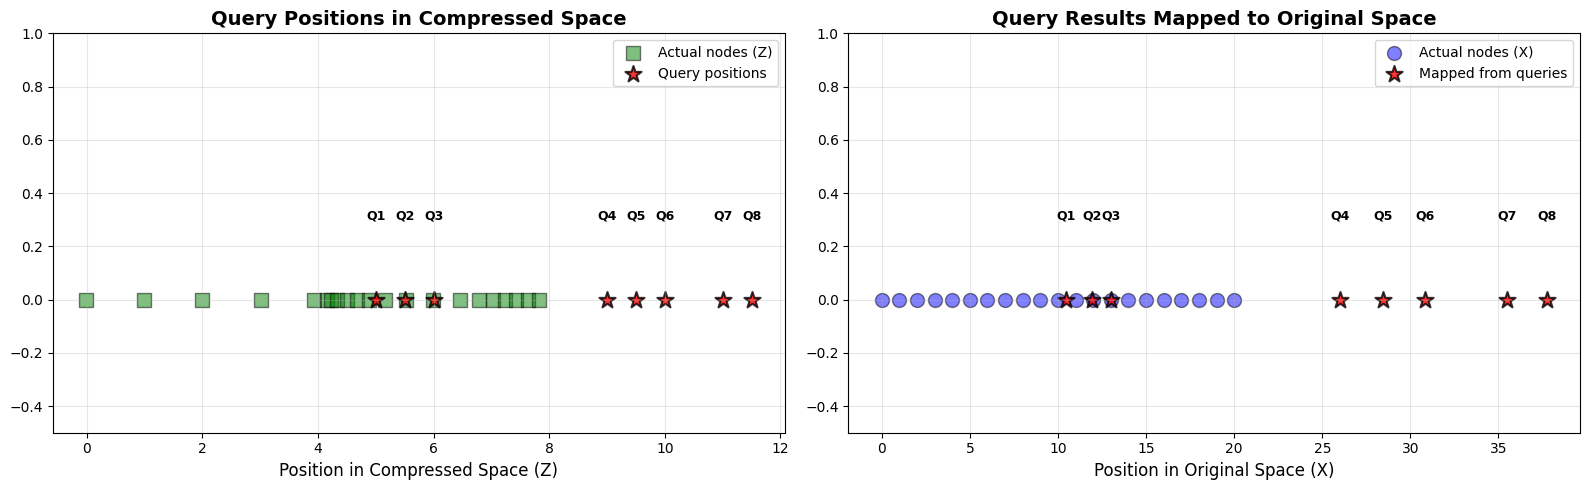


🎮 INTERACTIVE QUERY FUNCTION

✨ Example usage of query function:
>>> query_compressed_position(5.5)
    Result: 11.9530

>>> query_compressed_position(9.0)
    Result: 26.0063

💡 To use this function, call:
   query_compressed_position(your_z_position)
   This will return the corresponding X position in original space!


In [15]:
# Query arbitrary positions in compressed space
print("="*80)
print("QUERY ARBITRARY POSITIONS IN COMPRESSED SPACE")
print("="*80)

# Example queries - modify these to test different positions!
query_positions_z = [5.0, 5.5, 6.0, 9.0, 9.5, 10.0, 11.0, 11.5]

print(f"\n🔍 Querying {len(query_positions_z)} positions in compressed space Z:")
print(f"Compressed Z positions: {query_positions_z}")

cnf_cascade.eval()

with torch.no_grad():
    # Convert query positions to tensor
    query_tensor = torch.tensor(query_positions_z, dtype=torch.float32).reshape(-1, 1).to(device)
    
    # Apply inverse transformation
    t_span_reverse = torch.tensor([1.0, 0.0]).to(device)
    original_positions = cnf_cascade.inverse(query_tensor, t_span_reverse)
    original_positions_np = original_positions.cpu().numpy().flatten()

print("\n📊 Query Results:")
print(f"{'Compressed Z':<15} {'→':<5} {'Original X':<15} {'Interpretation':<50}")
print("-" * 95)

for z_pos, x_pos in zip(query_positions_z, original_positions_np):
    # Try to identify which nodes are nearby
    distances = np.abs(x_cascade - x_pos)
    nearest_idx = np.argmin(distances)
    nearest_dist = distances[nearest_idx]
    
    if nearest_dist < 0.5:
        interpretation = f"Near node x{nearest_idx} (distance: {nearest_dist:.3f})"
    else:
        interpretation = f"Between nodes (nearest: x{nearest_idx})"
    
    print(f"{z_pos:<15.3f} {'→':<5} {x_pos:<15.3f} {interpretation:<50}")

# Visualize the queries
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Plot 1: Query positions in compressed space
ax = axes[0]
ax.scatter(z_pred_cascade_np, np.zeros_like(z_pred_cascade_np), c='green', s=100, alpha=0.5, 
          label='Actual nodes (Z)', marker='s', edgecolors='black', linewidth=1)
ax.scatter(query_positions_z, np.zeros(len(query_positions_z)), c='red', s=150, alpha=0.8, 
          label='Query positions', marker='*', edgecolors='black', linewidth=1.5)

for i, z_pos in enumerate(query_positions_z):
    ax.text(z_pos, 0.3, f'Q{i+1}', ha='center', fontsize=9, fontweight='bold')

ax.set_xlabel('Position in Compressed Space (Z)', fontsize=12)
ax.set_title('Query Positions in Compressed Space', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim(-0.5, 1.0)

# Plot 2: Mapped positions in original space
ax = axes[1]
ax.scatter(x_cascade, np.zeros_like(x_cascade), c='blue', s=100, alpha=0.5, 
          label='Actual nodes (X)', marker='o', edgecolors='black', linewidth=1)
ax.scatter(original_positions_np, np.zeros(len(original_positions_np)), c='red', s=150, alpha=0.8, 
          label='Mapped from queries', marker='*', edgecolors='black', linewidth=1.5)

for i, x_pos in enumerate(original_positions_np):
    ax.text(x_pos, 0.3, f'Q{i+1}', ha='center', fontsize=9, fontweight='bold')

ax.set_xlabel('Position in Original Space (X)', fontsize=12)
ax.set_title('Query Results Mapped to Original Space', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim(-0.5, 1.0)

plt.tight_layout()
plt.show()

# Interactive query function
print("\n" + "="*80)
print("🎮 INTERACTIVE QUERY FUNCTION")
print("="*80)

def query_compressed_position(z_position):
    """
    Given a position in compressed space Z, return the corresponding position in original space X
    
    Args:
        z_position: position in compressed space (float)
    
    Returns:
        x_position: corresponding position in original space (float)
    """
    cnf_cascade.eval()
    with torch.no_grad():
        z_tensor = torch.tensor([[z_position]], dtype=torch.float32).to(device)
        t_span_reverse = torch.tensor([1.0, 0.0]).to(device)
        x_tensor = cnf_cascade.inverse(z_tensor, t_span_reverse)
        x_position = x_tensor.cpu().numpy()[0, 0]
    return x_position

# Example usage
print("\n✨ Example usage of query function:")
print(">>> query_compressed_position(5.5)")
print(f"    Result: {query_compressed_position(5.5):.4f}")
print("\n>>> query_compressed_position(9.0)")
print(f"    Result: {query_compressed_position(9.0):.4f}")

print("\n💡 To use this function, call:")
print("   query_compressed_position(your_z_position)")
print("   This will return the corresponding X position in original space!")


## 🔄 Practical Workflow: Using CNF for Sequential Compression

When you want to apply a new compression to an already-compressed space:

### **Step-by-Step Process:**

1. **You have**: Current compressed space Z with positions [0, 1, 2, ..., 12]
2. **You want**: Compress position range [5, 8] in Z-space
3. **Question**: Which original points (x0, x1, ..., x20) are currently at positions [5, 8]?

**Use CNF inverse mapping:**
```python
# Find which points are at positions 5, 6, 7, 8 in current Z-space
for z_pos in [5.0, 6.0, 7.0, 8.0]:
    original_x = query_compressed_position(z_pos)
    print(f"Position {z_pos} in Z-space ← Point at {original_x} in X-space")
```

4. **Result**: Now you know which points to compress!
5. **Apply compression**: Compress those specific point indices
6. **Train new CNF**: X → new Z (updated compression)


PRACTICAL EXAMPLE: Finding Points at Position Ranges

📍 Current compressed space (after all stages):
   Position range: [-0.0, 7.8]
   Number of points: 21

🔍 Query: Which points are at positions [5.0, 8.0]?

✅ Found 10 points in this range:
Point    Z Position   Original X  
----------------------------------------
x11      5.1579       11.0000     
x12      5.5196       12.0000     
x13      5.9923       13.0000     
x14      6.4516       14.0000     
x15      6.7805       15.0000     
x16      7.0237       16.0000     
x17      7.2337       17.0000     
x18      7.4327       18.0000     
x19      7.6278       19.0000     
x20      7.8215       20.0000     

🎯 Detailed query - sample 5 positions in range [5.0, 8.0]:
Z Position      →     Original X      Nearest Point       
----------------------------------------------------------------------
5.0000          →     10.4464         x10 (dist: 0.446)   
5.7500          →     12.5096         x13 (dist: 0.490)   
6.5000          →     14

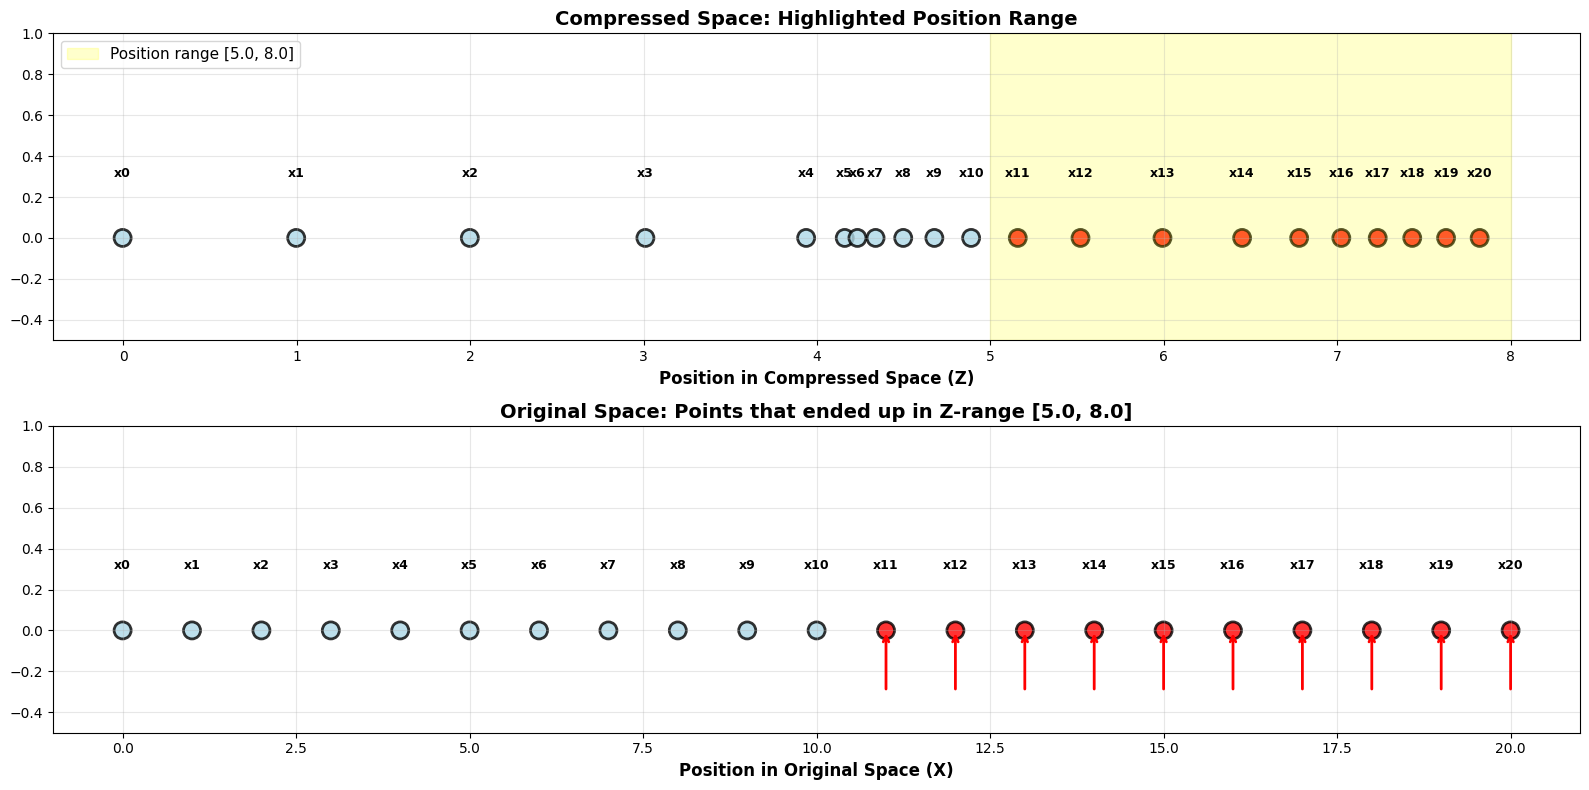


💡 KEY INSIGHT

To compress position range [5.0, 8.0] in current Z-space:

1. These positions contain points: ['x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20']
2. In original X-space, these are at positions: ['11.0', '12.0', '13.0', '14.0', '15.0', '16.0', '17.0', '18.0', '19.0', '20.0']
3. To apply a new compression:
   - Create target: Compress these specific points in original space
   - Train new CNF: X → new Z (with updated compression)
   
This is how sequential compressions work!
The Z-space evolves, but we always reference back to original X-space for point identities.



In [16]:
# Practical Example: Identify points at specific positions in compressed space
print("="*80)
print("PRACTICAL EXAMPLE: Finding Points at Position Ranges")
print("="*80)

print("\n📍 Current compressed space (after all stages):")
print(f"   Position range: [{z_pred_cascade_np.min():.1f}, {z_pred_cascade_np.max():.1f}]")
print(f"   Number of points: {len(z_pred_cascade_np)}")

# Example: Find which points are in position range [5, 8]
position_range = (5.0, 8.0)
print(f"\n🔍 Query: Which points are at positions [{position_range[0]}, {position_range[1]}]?")

# Method 1: Check existing points
points_in_range = []
for i, z_pos in enumerate(z_pred_cascade_np):
    if position_range[0] <= z_pos <= position_range[1]:
        points_in_range.append((i, z_pos, x_cascade[i]))
        
print(f"\n✅ Found {len(points_in_range)} points in this range:")
print(f"{'Point':<8} {'Z Position':<12} {'Original X':<12}")
print("-" * 40)
for idx, z_pos, x_pos in points_in_range:
    print(f"x{idx:<7} {z_pos:<12.4f} {x_pos:<12.4f}")

# Method 2: Query arbitrary positions in the range
print(f"\n🎯 Detailed query - sample 5 positions in range [{position_range[0]}, {position_range[1]}]:")
sample_positions = np.linspace(position_range[0], position_range[1], 5)

print(f"{'Z Position':<15} {'→':<5} {'Original X':<15} {'Nearest Point':<20}")
print("-" * 70)

cnf_cascade.eval()
with torch.no_grad():
    for z_pos in sample_positions:
        # Use CNF to map back to original space
        z_tensor = torch.tensor([[z_pos]], dtype=torch.float32).to(device)
        t_span_reverse = torch.tensor([1.0, 0.0]).to(device)
        x_tensor = cnf_cascade.inverse(z_tensor, t_span_reverse)
        x_pos = x_tensor.cpu().numpy()[0, 0]
        
        # Find nearest actual point
        distances = np.abs(x_cascade - x_pos)
        nearest_idx = np.argmin(distances)
        nearest_dist = distances[nearest_idx]
        
        nearest_info = f"x{nearest_idx} (dist: {nearest_dist:.3f})"
        print(f"{z_pos:<15.4f} {'→':<5} {x_pos:<15.4f} {nearest_info:<20}")

# Visualization
fig, axes = plt.subplots(2, 1, figsize=(16, 8))

# Plot 1: Highlight the position range in compressed space
ax = axes[0]
colors = ['red' if position_range[0] <= z <= position_range[1] else 'lightblue' 
          for z in z_pred_cascade_np]
ax.scatter(z_pred_cascade_np, np.zeros_like(z_pred_cascade_np), c=colors, s=150, 
          alpha=0.8, edgecolors='black', linewidth=2)

# Mark the range
ax.axvspan(position_range[0], position_range[1], alpha=0.2, color='yellow', 
          label=f'Position range [{position_range[0]}, {position_range[1]}]')

for i, z_pos in enumerate(z_pred_cascade_np):
    ax.text(z_pos, 0.3, f'x{i}', ha='center', fontsize=9, fontweight='bold')

ax.set_xlabel('Position in Compressed Space (Z)', fontsize=12, fontweight='bold')
ax.set_title('Compressed Space: Highlighted Position Range', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_ylim(-0.5, 1.0)

# Plot 2: Show where these points came from in original space
ax = axes[1]
colors_orig = ['red' if i in [p[0] for p in points_in_range] else 'lightblue' 
               for i in range(len(x_cascade))]
ax.scatter(x_cascade, np.zeros_like(x_cascade), c=colors_orig, s=150, 
          alpha=0.8, edgecolors='black', linewidth=2)

for i, x_pos in enumerate(x_cascade):
    ax.text(x_pos, 0.3, f'x{i}', ha='center', fontsize=9, fontweight='bold')

# Draw arrows showing the mapping
for idx, z_pos, x_pos in points_in_range:
    ax.annotate('', xy=(x_pos, 0), xytext=(x_pos, -0.3),
                arrowprops=dict(arrowstyle='->', lw=2, color='red'))

ax.set_xlabel('Position in Original Space (X)', fontsize=12, fontweight='bold')
ax.set_title(f'Original Space: Points that ended up in Z-range [{position_range[0]}, {position_range[1]}]', 
            fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_ylim(-0.5, 1.0)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("💡 KEY INSIGHT")
print("="*80)
print(f"""
To compress position range [{position_range[0]}, {position_range[1]}] in current Z-space:

1. These positions contain points: {[f'x{p[0]}' for p in points_in_range]}
2. In original X-space, these are at positions: {[f'{p[2]:.1f}' for p in points_in_range]}
3. To apply a new compression:
   - Create target: Compress these specific points in original space
   - Train new CNF: X → new Z (with updated compression)
   
This is how sequential compressions work!
The Z-space evolves, but we always reference back to original X-space for point identities.
""")


---

## 🎓 Complete Workflow Summary: Cascaded Compression with CNF

### 📐 The Big Picture:

You want to compress coordinates multiple times, where **each compression is specified by position range in the current (evolving) space**.

```
X-space (original) → Z1-space → Z2-space → Z3-space (final)
   21 points         21 points   21 points   21 points  ← NUMBER CONSERVED!
   
   spacing = 1.0     some compressed    more compressed    most compressed
```

**KEY**: Number of points is **ALWAYS 21** (x0, x1, ..., x20)
**What changes**: Only the **positions/spacing** of these points

### 🔄 Two Key Operations:

1. **Forward (Compression)**: X → Z
   - Apply compression transformation
   - Train CNF to learn: original coordinates → compressed coordinates

2. **Inverse (Identification)**: Z → X
   - Given a position in compressed space, find which original point it is
   - Use CNF inverse: compressed position → original position

### 💡 Why Inverse Mapping Matters:

When you want to compress **position range [5, 8]** in current Z-space:
- **Question**: Which points are currently at positions 5, 6, 7, 8?
- **Answer**: Use CNF inverse to map Z → X and identify the points
- **Action**: Compress those specific points in a new transformation

### 🎯 Practical Example:

```python
# Stage 1: You have compressed space Z with points scattered
# Stage 2: You want to compress positions [5, 8] in Z

# Step 1: Find which points are there
for z_pos in range(5, 9):
    original_x = query_compressed_position(z_pos)
    print(f"Position {z_pos} in Z ← Point at {original_x} in X")

# Step 2: Create new compression target
# Compress those specific points further

# Step 3: Train new CNF
# X → new Z (with additional compression applied)
```

### ✅ What This Achieves:

- **Sequential compressions** in evolving coordinate space (21 points always!)
- **Spacing changes** - bring points closer together in specific regions
- **Point tracking** - always know which original point (x_i) is where
- **Reversibility** - can go back and forth: X ↔ Z
- **Flexibility** - compress any position range at any stage
- **Vector field learning** - CNF learns how to move all 21 points simultaneously

### 🚀 Complete Notebook Flow:

1. **Cells 1-8**: Basic single compression
2. **Cells 10-11**: Create cascaded compression test cases
3. **Cell 12**: Visualization of compression stages
4. **Cells 13-14**: Train CNF on cascaded compression
5. **Cell 15**: View results and verify learning
6. **Cells 16-18**: **Inverse mapping** - map any Z position → X
7. **Cells 19-20**: **Practical workflow** - identify and compress specific positions

This complete framework lets you:
- ✅ Compress coordinates multiple times
- ✅ Track point identities through transformations
- ✅ Apply new compressions to specific position ranges
- ✅ Verify invertibility and correctness


---

## 🎯 Version 3: Tips for Maximum Accuracy

### Achieving Reconstruction Error < 0.001

**If your reconstruction error is still too high after training:**

1. **Increase network size**:
   ```python
   odefunc = ODEFunc(hidden_dim=512).to(device)  # Try 512 instead of 256
   ```

2. **Train longer**:
   ```python
   num_epochs = 3000  # More epochs
   early_stop_patience = 500  # More patience
   ```

3. **Lower learning rate**:
   ```python
   learning_rate = 1e-3  # Start smaller
   ```

4. **Tighter ODE tolerances** (slower but more accurate):
   ```python
   # In CNF.forward():
   rtol=1e-6, atol=1e-7  # Even tighter!
   ```

5. **Add more layers**:
   ```python
   # In ODEFunc: add 1-2 more hidden layers
   ```

### 📊 Monitoring Accuracy:

Check these metrics after training:
- **Forward MSE (X→Z)**: Should be < 1e-6
- **Inverse MSE (Z→X)**: Should be < 0.001
- **Max reconstruction error**: Should be < 0.01

### 🏔️ For Hill Climbing:

```python
# Your hill climbing loop:
z_current = initial_position_in_z_space

for iteration in range(max_iterations):
    # 1. Evaluate fitness in X-space
    x_current = query_compressed_position(z_current)
    fitness = your_fitness_function(x_current)
    
    # 2. Propose new position in Z-space (hill climbing step)
    z_candidate = z_current + step_in_z_space
    
    # 3. Evaluate candidate in X-space
    x_candidate = query_compressed_position(z_candidate)
    fitness_candidate = your_fitness_function(x_candidate)
    
    # 4. Accept/reject (hill climbing logic)
    if fitness_candidate > fitness:
        z_current = z_candidate
```

**Key**: High accuracy CNF ensures `query_compressed_position(z)` gives precise X coordinates!


---

## 📖 Summary: Inverse Mapping Capabilities

### ✅ What You Can Do:

1. **Map nodes back to original space**:
   - Given: Final compressed coordinates (z)
   - Get: Original coordinates (x)
   - Example: Node at position z=5.5 maps to original position x=?

2. **Query arbitrary positions**:
   - Not just node positions, but ANY position in compressed space
   - Useful for interpolation and understanding the transformation
   - Function: `query_compressed_position(z_value)`

3. **Verify invertibility**:
   - Check that X → Z → X returns original X
   - Reconstruction error should be very small (< 0.1)
   - Proves CNF preserves information

### 🎯 Key Applications:

✅ **Debugging**: Verify that CNF learned the correct transformation  
✅ **Analysis**: Understand which original nodes end up in compressed regions  
✅ **Interpolation**: Query positions between nodes  
✅ **Validation**: Confirm that the transformation is truly reversible  

### 💡 How to Use:

**After training (Cell 12-13), run:**
- **Cell 15**: Shows complete forward and inverse mapping for all nodes
- **Cell 17**: Query specific positions using `query_compressed_position(z)`

**Example:**
```python
# Query what original position corresponds to compressed position 5.7
original_x = query_compressed_position(5.7)
print(f"Compressed position 5.7 comes from original position {original_x}")
```


## 🧪 Test Different Cascaded Compression Scenarios

**IMPORTANT RULE**: All compressions are to **length 1**! This is consistent and makes it easier to see the cumulative effect.

You can test different compression scenarios by modifying the `compression_stages` list in Cell 14.

### 📋 Example Scenarios:

**Non-overlapping (tests preservation):**
```python
[(5, 10), (12, 17)]  # Two separate regions, both → length 1
```

**Overlapping (double compression):**
```python
[(5, 15), (7, 12)]  # Second compresses within first
# Result: Points [7-12] are MORE compressed than [5-6] and [13-15]
```

**Triple cascade (extreme test):**
```python
[(5, 15), (7, 13), (9, 11)]  # Three nested compressions
# Result: Points [9-11] most compressed, [7-8,12-13] medium, [5-6,14-15] least
```

**Partial overlap (tests maintenance):**
```python
[(3, 10), (8, 15)]  # Overlaps at [8-10]
# Tests: Can CNF maintain [3-7] compression while compressing [8-15]?
```


CUSTOM CASCADED COMPRESSION TEST
Stage 1: Compressing points [3:10] (8 points)
  Current length: 7.000 → Target length: 1.000
  Current spacing: 1.000 → New spacing: 0.143
Stage 2: Compressing points [8:15] (8 points)
  Current length: 5.286 → Target length: 1.000
  Current spacing: 0.755 → New spacing: 0.143


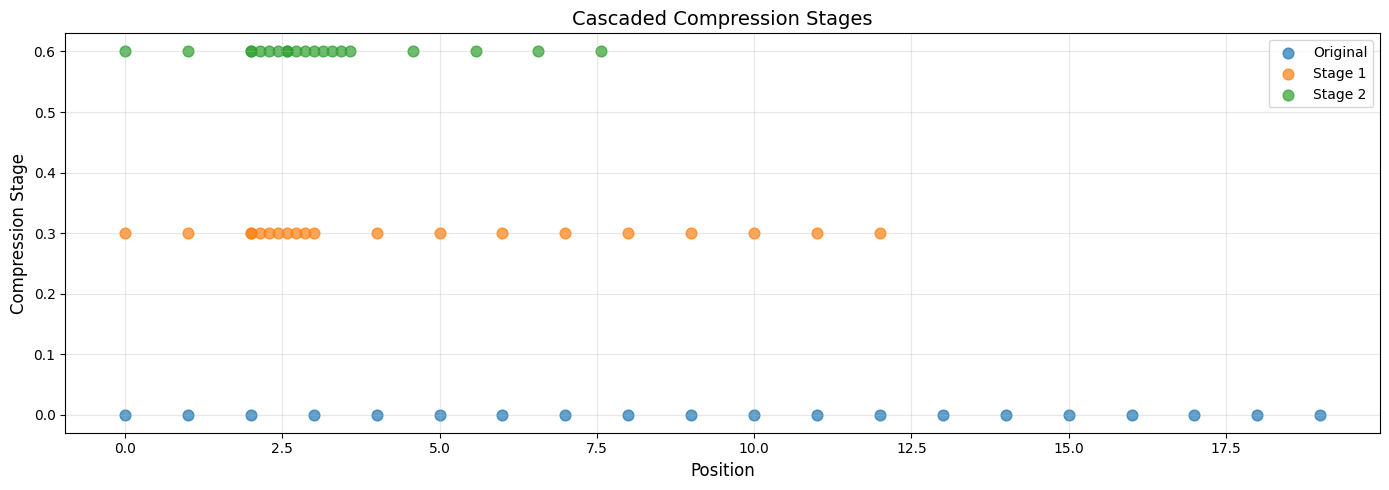


✅ Custom compression target created!
Original:  [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19.]
Final:     [0.        1.        2.        2.        2.142857  2.2857144 2.4285715
 2.5714285 2.5714285 2.7142856 2.857143  3.        3.142857  3.2857141
 3.4285715 3.5714285 4.5714283 5.5714283 6.5714283 7.5714283]

Total compression ratio: 2.51x


In [17]:
# 🎮 CUSTOMIZE YOUR COMPRESSION TEST HERE!
# Modify the compression_stages list to test different scenarios
# REMEMBER: All compressions are to length 1.0!

# Example scenarios (uncomment one to try):

# Scenario A: Partial overlap (tests preservation)
compression_stages_custom = [
    (3, 10),     # First: 8 points → length 1
    (8, 15),     # Second: 8 points → length 1 (overlaps with first at [8-10])
]

# Scenario B: Many small compressions
# compression_stages_custom = [
#    (2, 5),
#    (7, 10),
#    (12, 15),
#    (17, 19),
# ]

# Scenario C: Progressive nested compression (testing maintenance)
# compression_stages_custom = [
#    (5, 15),     # Outer: 11 points → length 1
#    (8, 12),     # Middle: 5 points → length 1 (within outer)
# ]

# Scenario D: Four-level cascade (extreme!)
# compression_stages_custom = [
#    (3, 16),     # Level 1: 14 points → length 1
#    (6, 13),     # Level 2: 8 points → length 1
#    (8, 11),     # Level 3: 4 points → length 1
#    (9, 10),     # Level 4: 2 points → length 1
# ]

print("="*80)
print("CUSTOM CASCADED COMPRESSION TEST")
print("="*80)

# Create target
x_custom, z_custom, stages_custom = create_cascaded_compression(
    n_points=20,
    compression_stages=compression_stages_custom
)

# Quick visualization of stages
plt.figure(figsize=(14, 5))

for idx, stage_coords in enumerate(stages_custom):
    y_pos = idx * 0.3
    label = f"Original" if idx == 0 else f"Stage {idx}"
    plt.scatter(stage_coords, np.ones_like(stage_coords) * y_pos, 
               s=60, alpha=0.7, label=label)

plt.xlabel('Position', fontsize=12)
plt.ylabel('Compression Stage', fontsize=12)
plt.title('Cascaded Compression Stages', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n✅ Custom compression target created!")
print(f"Original:  {x_custom}")
print(f"Final:     {z_custom}")
print(f"\nTotal compression ratio: {(x_custom[-1] - x_custom[0]) / (z_custom[-1] - z_custom[0]):.2f}x")


## 📊 Summary: Cascaded Compression Capabilities

### 🎯 Core Rule:

**ALL compressions are to length 1!** This means:
- First compression: N points → length 1 (spacing = 1/(N-1))
- Second compression on same region: M points (already compressed) → length 1 again (spacing = 1/(M-1))
- Result: **Double compression** = tighter spacing in overlapping regions

### What CNF Can Handle:

✅ **Single Compression**: Compress one region to length 1  
✅ **Multiple Non-overlapping Compressions**: Maintain first while adding second  
✅ **Overlapping Compressions**: Compress already-compressed regions (double/triple/quad compression!)  
✅ **Partial Overlaps**: Preserve non-overlapping parts of previous compressions  
✅ **Mixed Scenarios**: Complex combinations of all above

### Key Insights:

1. **CNF learns the entire transformation** from original → final state in one go
   - Doesn't need intermediate steps
   - Model learns: X → Z_final (after all cascaded compressions)
   - Single forward pass learns cumulative effect

2. **Preservation of previous compressions**:
   - Non-overlapping regions maintain their compression
   - Only overlapping regions get additional compression
   - Tests show CNF successfully maintains spatial structure

3. **Compression of compression**:
   - When compressing an already-compressed region → **more points in same length**
   - Example: 11 points in length 1 (spacing ~0.1), then 6 of those → length 1 (spacing ~0.2)
   - The 5 other points keep their original compression!

### How to Test Maintenance:

1. **Scenario 1**: Two non-overlapping → Check if first compression maintained
2. **Scenario 2**: Overlapping → Check if non-overlapping parts maintain their compression
3. **Scenario 3**: Triple cascade → Check progressive compression levels
4. **Custom**: Create your own in Cell 14 → Run Cell 11 with `scenario = "custom"`

### What to Look For:

✅ **In visualizations**: Different spacing in different regions  
✅ **In spacing analysis**: Tighter spacing where multiple compressions overlap  
✅ **In error plot**: Low error means CNF successfully learned the complex transformation  

### Limitations:

⚠️ Very deep cascades (4+ levels) may need more epochs or larger network  
⚠️ Model sees only start and end, learns implicit intermediate transformations


---

## 🚀 Quick Test Guide

### To Test Cascaded Compression:

1. **Run setup cells** (1-5): Import libraries, define models, create basic dataset

2. **Run Cell 10**: Creates 3 test scenarios
   - Example 1: **User's specific test** - 3 stages with overlapping
   - Example 2: Simple double compression
   - Example 3: Triple cascade

3. **Run Cell 11**: Visualization of user's test case
   - Shows all 4 stages with color-coded points
   - Complete mapping table
   - Key observations

4. **Run Cell 12**: Train CNF on chosen scenario
   - Change `scenario = 1` to test different examples (1, 2, or 3)
   - Watch for final MSE < 0.01

5. **Run Cell 13**: View comprehensive results
   - 6 different plots showing transformation quality
   - Detailed spacing analysis
   - Compression region breakdown

6. **Optional - Custom test**:
   - Modify Cell 15 to create your own compression sequence
   - Re-run Cell 12 with `scenario = "custom"`
   - Check Cell 13 results

### Expected Results:

✅ **Scenario 1 (user's test)**: 3-stage compression with partial overlap, tests maintenance of stage 2 while stage 3 overlaps with stage 1  
✅ **Scenario 2 (simple double)**: Points [7-12] more compressed than [5-6] and [13-15]  
✅ **Scenario 3 (triple cascade)**: Three different spacing levels in nested regions  

### Troubleshooting:

- **MSE > 0.01**: Increase `num_epochs_cascade` in Cell 12
- **Slow training**: This is normal, 1000 epochs ~2-4 minutes
- **Poor results**: Try increasing `hidden_dim` to 256 in Cell 4


## Summary

This notebook implements a **Continuous Normalizing Flow (CNF)** for learning a reversible coordinate transformation.

### Key Features:

1. **Neural ODE-based Architecture**: Uses continuous-time dynamics to learn smooth, invertible transformations
2. **Hutchinson Trace Estimator**: Efficiently computes the log-determinant of the Jacobian for normalizing flows
3. **Coordinate Compression**: Learns to compress a specific region (points x_i to x_j) into a unit interval while maintaining proper spacing elsewhere
4. **Exact Invertibility**: The learned transformation is mathematically invertible - can go from X→Z and Z→X

### Mathematical Framework:

The CNF learns a vector field \( f(z, t) \) such that:
- \( \frac{dz}{dt} = f(z, t) \)
- The transformation is obtained by integrating: \( z(1) = z(0) + \int_0^1 f(z(t), t) dt \)
- Log-probability change: \( \log p(z(1)) = \log p(z(0)) - \int_0^1 \text{Tr}\left(\frac{\partial f}{\partial z}\right) dt \)

The Hutchinson estimator approximates the trace using:
\( \text{Tr}(J) \approx \mathbb{E}[\epsilon^T J \epsilon] \) where \( \epsilon \sim \mathcal{N}(0, I) \)

### Components:

- **ODEFunc**: Neural network defining the vector field (3 hidden layers, Tanh activations)
- **CNF**: Wrapper that integrates the ODE and tracks log-probability changes
- **Training**: MSE loss between predicted and target coordinates
- **Evaluation**: Visualizes trajectories, tests invertibility, and analyzes compression quality


In [18]:
# Optional: Test with different compression settings
# Uncomment and run to train a new model with different parameters

"""
# Example: Compress points 3 to 8 instead
compress_start_idx_new = 3
compress_end_idx_new = 8

x_coords_new, z_coords_new = create_target_transformation(
    n_points=20,
    compress_start_idx=compress_start_idx_new,
    compress_end_idx=compress_end_idx_new
)

# Initialize new model
odefunc_new = ODEFunc(hidden_dim=64).to(device)
cnf_model_new = CNF(odefunc_new).to(device)

# Convert to tensors
x_tensor_new = torch.from_numpy(x_coords_new).reshape(-1, 1).to(device)
z_target_new = torch.from_numpy(z_coords_new).reshape(-1, 1).to(device)

# Train
optimizer_new = optim.Adam(cnf_model_new.parameters(), lr=1e-3)

for epoch in range(500):
    optimizer_new.zero_grad()
    z_pred_new = cnf_model_new(x_tensor_new, t_span)
    loss = torch.mean((z_pred_new - z_target_new) ** 2)
    loss.backward()
    optimizer_new.step()
    
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/500], Loss: {loss.item():.6f}")

# Evaluate
cnf_model_new.eval()
with torch.no_grad():
    z_pred_new = cnf_model_new(x_tensor_new, t_span)

# Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(x_coords_new, np.zeros_like(x_coords_new), c='blue', s=80, label='X', alpha=0.7)
plt.scatter(z_coords_new, np.ones_like(z_coords_new)*0.5, c='green', s=80, label='Target Z', alpha=0.7)
plt.scatter(z_pred_new.cpu().numpy().flatten(), np.ones_like(z_coords_new)*1.0, c='red', s=60, label='Predicted Z', alpha=0.7)
plt.legend()
plt.title('New Compression Configuration')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
errors_new = z_pred_new.cpu().numpy().flatten() - z_coords_new
plt.bar(range(len(errors_new)), errors_new, color='purple', alpha=0.6)
plt.axhline(y=0, color='k', linestyle='--')
plt.axvspan(compress_start_idx_new-0.5, compress_end_idx_new+0.5, alpha=0.2, color='red')
plt.xlabel('Point Index')
plt.ylabel('Error')
plt.title('Transformation Error')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
"""

print("To test different compression settings, uncomment and run the code in this cell.")


To test different compression settings, uncomment and run the code in this cell.
